# Afriat

In [1]:
ood_seed = 1

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('0', 'Periportal', 'Control')


Removed datapoint: 2659

train         13092
validation     3302
ood            2659
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 52%|█████▏    | 9867/19053 [00:00<00:00, 98664.68it/s]

100%|██████████| 19053/19053 [00:00<00:00, 99392.77it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1039776.13it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 411.96it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:08<57:07,  8.59s/it]

Epoch 1/400:   0%|          | 1/400 [00:08<57:07,  8.59s/it, v_num=1, recon=4.11e+3, r2_mean=0.166, adv_loss=3.29, acc_pert=0.243, acc_zone=0.732, acc_status_control=0.525]

Epoch 2/400:   0%|          | 1/400 [00:08<57:07,  8.59s/it, v_num=1, recon=4.11e+3, r2_mean=0.166, adv_loss=3.29, acc_pert=0.243, acc_zone=0.732, acc_status_control=0.525]

Epoch 2/400:   0%|          | 2/400 [00:16<55:50,  8.42s/it, v_num=1, recon=4.11e+3, r2_mean=0.166, adv_loss=3.29, acc_pert=0.243, acc_zone=0.732, acc_status_control=0.525]

Epoch 2/400:   0%|          | 2/400 [00:16<55:50,  8.42s/it, v_num=1, recon=3.32e+3, r2_mean=0.589, adv_loss=2.72, acc_pert=0.35, acc_zone=0.841, acc_status_control=0.705] 

Epoch 3/400:   0%|          | 2/400 [00:16<55:50,  8.42s/it, v_num=1, recon=3.32e+3, r2_mean=0.589, adv_loss=2.72, acc_pert=0.35, acc_zone=0.841, acc_status_control=0.705]

Epoch 3/400:   1%|          | 3/400 [00:25<55:10,  8.34s/it, v_num=1, recon=3.32e+3, r2_mean=0.589, adv_loss=2.72, acc_pert=0.35, acc_zone=0.841, acc_status_control=0.705]

Epoch 3/400:   1%|          | 3/400 [00:25<55:10,  8.34s/it, v_num=1, recon=3.25e+3, r2_mean=0.701, adv_loss=2.57, acc_pert=0.357, acc_zone=0.839, acc_status_control=0.713]

Epoch 4/400:   1%|          | 3/400 [00:25<55:10,  8.34s/it, v_num=1, recon=3.25e+3, r2_mean=0.701, adv_loss=2.57, acc_pert=0.357, acc_zone=0.839, acc_status_control=0.713]

Epoch 4/400:   1%|          | 4/400 [00:33<54:43,  8.29s/it, v_num=1, recon=3.25e+3, r2_mean=0.701, adv_loss=2.57, acc_pert=0.357, acc_zone=0.839, acc_status_control=0.713]

Epoch 4/400:   1%|          | 4/400 [00:33<54:43,  8.29s/it, v_num=1, recon=3.23e+3, r2_mean=0.741, adv_loss=2.46, acc_pert=0.387, acc_zone=0.836, acc_status_control=0.715]

Epoch 5/400:   1%|          | 4/400 [00:33<54:43,  8.29s/it, v_num=1, recon=3.23e+3, r2_mean=0.741, adv_loss=2.46, acc_pert=0.387, acc_zone=0.836, acc_status_control=0.715]

Epoch 5/400:   1%|▏         | 5/400 [00:41<54:28,  8.27s/it, v_num=1, recon=3.23e+3, r2_mean=0.741, adv_loss=2.46, acc_pert=0.387, acc_zone=0.836, acc_status_control=0.715]

Epoch 5/400:   1%|▏         | 5/400 [00:41<54:28,  8.27s/it, v_num=1, recon=3.22e+3, r2_mean=0.764, adv_loss=2.28, acc_pert=0.437, acc_zone=0.85, acc_status_control=0.718] 

Epoch 6/400:   1%|▏         | 5/400 [00:41<54:28,  8.27s/it, v_num=1, recon=3.22e+3, r2_mean=0.764, adv_loss=2.28, acc_pert=0.437, acc_zone=0.85, acc_status_control=0.718]

Epoch 6/400:   2%|▏         | 6/400 [00:49<54:18,  8.27s/it, v_num=1, recon=3.22e+3, r2_mean=0.764, adv_loss=2.28, acc_pert=0.437, acc_zone=0.85, acc_status_control=0.718]

Epoch 6/400:   2%|▏         | 6/400 [00:49<54:18,  8.27s/it, v_num=1, recon=3.21e+3, r2_mean=0.782, adv_loss=2.12, acc_pert=0.486, acc_zone=0.856, acc_status_control=0.716]

Epoch 7/400:   2%|▏         | 6/400 [00:49<54:18,  8.27s/it, v_num=1, recon=3.21e+3, r2_mean=0.782, adv_loss=2.12, acc_pert=0.486, acc_zone=0.856, acc_status_control=0.716]

Epoch 7/400:   2%|▏         | 7/400 [00:58<53:58,  8.24s/it, v_num=1, recon=3.21e+3, r2_mean=0.782, adv_loss=2.12, acc_pert=0.486, acc_zone=0.856, acc_status_control=0.716]

Epoch 7/400:   2%|▏         | 7/400 [00:58<53:58,  8.24s/it, v_num=1, recon=3.2e+3, r2_mean=0.792, adv_loss=1.97, acc_pert=0.54, acc_zone=0.854, acc_status_control=0.72]   

Epoch 8/400:   2%|▏         | 7/400 [00:58<53:58,  8.24s/it, v_num=1, recon=3.2e+3, r2_mean=0.792, adv_loss=1.97, acc_pert=0.54, acc_zone=0.854, acc_status_control=0.72]

Epoch 8/400:   2%|▏         | 8/400 [01:06<53:47,  8.23s/it, v_num=1, recon=3.2e+3, r2_mean=0.792, adv_loss=1.97, acc_pert=0.54, acc_zone=0.854, acc_status_control=0.72]

Epoch 8/400:   2%|▏         | 8/400 [01:06<53:47,  8.23s/it, v_num=1, recon=3.2e+3, r2_mean=0.8, adv_loss=1.88, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.721] 

Epoch 9/400:   2%|▏         | 8/400 [01:06<53:47,  8.23s/it, v_num=1, recon=3.2e+3, r2_mean=0.8, adv_loss=1.88, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.721]

Epoch 9/400:   2%|▏         | 9/400 [01:14<53:28,  8.21s/it, v_num=1, recon=3.2e+3, r2_mean=0.8, adv_loss=1.88, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.721]

Epoch 9/400:   2%|▏         | 9/400 [01:14<53:28,  8.21s/it, v_num=1, recon=3.18e+3, r2_mean=0.808, adv_loss=1.76, acc_pert=0.606, acc_zone=0.85, acc_status_control=0.719]

Epoch 10/400:   2%|▏         | 9/400 [01:14<53:28,  8.21s/it, v_num=1, recon=3.18e+3, r2_mean=0.808, adv_loss=1.76, acc_pert=0.606, acc_zone=0.85, acc_status_control=0.719]


disnt_basal = 1.2745815710981885

disnt_after = 1.7350850905487187

val_r2_mean = 0.8116202537688335

val_r2_var = 0.18390608662038627


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:26<1:01:49,  9.51s/it, v_num=1, recon=3.18e+3, r2_mean=0.808, adv_loss=1.76, acc_pert=0.606, acc_zone=0.85, acc_status_control=0.719]

Epoch 10/400:   2%|▎         | 10/400 [01:26<1:01:49,  9.51s/it, v_num=1, recon=3.18e+3, r2_mean=0.811, adv_loss=1.69, acc_pert=0.642, acc_zone=0.855, acc_status_control=0.721, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:26<1:01:49,  9.51s/it, v_num=1, recon=3.18e+3, r2_mean=0.811, adv_loss=1.69, acc_pert=0.642, acc_zone=0.855, acc_status_control=0.721, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:35<59:10,  9.13s/it, v_num=1, recon=3.18e+3, r2_mean=0.811, adv_loss=1.69, acc_pert=0.642, acc_zone=0.855, acc_status_control=0.721, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]  

Epoch 11/400:   3%|▎         | 11/400 [01:35<59:10,  9.13s/it, v_num=1, recon=3.17e+3, r2_mean=0.814, adv_loss=1.64, acc_pert=0.661, acc_zone=0.851, acc_status_control=0.725, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:35<59:10,  9.13s/it, v_num=1, recon=3.17e+3, r2_mean=0.814, adv_loss=1.64, acc_pert=0.661, acc_zone=0.851, acc_status_control=0.725, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:43<57:24,  8.88s/it, v_num=1, recon=3.17e+3, r2_mean=0.814, adv_loss=1.64, acc_pert=0.661, acc_zone=0.851, acc_status_control=0.725, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:43<57:24,  8.88s/it, v_num=1, recon=3.17e+3, r2_mean=0.816, adv_loss=1.6, acc_pert=0.679, acc_zone=0.856, acc_status_control=0.723, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [01:43<57:24,  8.88s/it, v_num=1, recon=3.17e+3, r2_mean=0.816, adv_loss=1.6, acc_pert=0.679, acc_zone=0.856, acc_status_control=0.723, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:51<56:01,  8.69s/it, v_num=1, recon=3.17e+3, r2_mean=0.816, adv_loss=1.6, acc_pert=0.679, acc_zone=0.856, acc_status_control=0.723, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:51<56:01,  8.69s/it, v_num=1, recon=3.16e+3, r2_mean=0.82, adv_loss=1.57, acc_pert=0.688, acc_zone=0.855, acc_status_control=0.723, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:51<56:01,  8.69s/it, v_num=1, recon=3.16e+3, r2_mean=0.82, adv_loss=1.57, acc_pert=0.688, acc_zone=0.855, acc_status_control=0.723, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:59<55:09,  8.57s/it, v_num=1, recon=3.16e+3, r2_mean=0.82, adv_loss=1.57, acc_pert=0.688, acc_zone=0.855, acc_status_control=0.723, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:59<55:09,  8.57s/it, v_num=1, recon=3.15e+3, r2_mean=0.819, adv_loss=1.54, acc_pert=0.709, acc_zone=0.856, acc_status_control=0.727, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:59<55:09,  8.57s/it, v_num=1, recon=3.15e+3, r2_mean=0.819, adv_loss=1.54, acc_pert=0.709, acc_zone=0.856, acc_status_control=0.727, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:08<54:15,  8.46s/it, v_num=1, recon=3.15e+3, r2_mean=0.819, adv_loss=1.54, acc_pert=0.709, acc_zone=0.856, acc_status_control=0.727, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:08<54:15,  8.46s/it, v_num=1, recon=3.15e+3, r2_mean=0.823, adv_loss=1.51, acc_pert=0.717, acc_zone=0.857, acc_status_control=0.727, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:08<54:15,  8.46s/it, v_num=1, recon=3.15e+3, r2_mean=0.823, adv_loss=1.51, acc_pert=0.717, acc_zone=0.857, acc_status_control=0.727, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:16<53:31,  8.36s/it, v_num=1, recon=3.15e+3, r2_mean=0.823, adv_loss=1.51, acc_pert=0.717, acc_zone=0.857, acc_status_control=0.727, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:16<53:31,  8.36s/it, v_num=1, recon=3.15e+3, r2_mean=0.825, adv_loss=1.51, acc_pert=0.718, acc_zone=0.857, acc_status_control=0.725, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:16<53:31,  8.36s/it, v_num=1, recon=3.15e+3, r2_mean=0.825, adv_loss=1.51, acc_pert=0.718, acc_zone=0.857, acc_status_control=0.725, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:24<53:05,  8.32s/it, v_num=1, recon=3.15e+3, r2_mean=0.825, adv_loss=1.51, acc_pert=0.718, acc_zone=0.857, acc_status_control=0.725, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:24<53:05,  8.32s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=1.49, acc_pert=0.727, acc_zone=0.852, acc_status_control=0.73, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [02:24<53:05,  8.32s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=1.49, acc_pert=0.727, acc_zone=0.852, acc_status_control=0.73, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:32<52:43,  8.28s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=1.49, acc_pert=0.727, acc_zone=0.852, acc_status_control=0.73, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:32<52:43,  8.28s/it, v_num=1, recon=3.14e+3, r2_mean=0.828, adv_loss=1.49, acc_pert=0.715, acc_zone=0.851, acc_status_control=0.73, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:32<52:43,  8.28s/it, v_num=1, recon=3.14e+3, r2_mean=0.828, adv_loss=1.49, acc_pert=0.715, acc_zone=0.851, acc_status_control=0.73, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:40<52:26,  8.26s/it, v_num=1, recon=3.14e+3, r2_mean=0.828, adv_loss=1.49, acc_pert=0.715, acc_zone=0.851, acc_status_control=0.73, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:40<52:26,  8.26s/it, v_num=1, recon=3.13e+3, r2_mean=0.828, adv_loss=1.48, acc_pert=0.731, acc_zone=0.852, acc_status_control=0.731, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [02:40<52:26,  8.26s/it, v_num=1, recon=3.13e+3, r2_mean=0.828, adv_loss=1.48, acc_pert=0.731, acc_zone=0.852, acc_status_control=0.731, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]


disnt_basal = 1.3002791866673937

disnt_after = 1.7569187554687933

val_r2_mean = 0.8291123912252231

val_r2_var = 0.22060594815325804


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [02:53<1:00:15,  9.51s/it, v_num=1, recon=3.13e+3, r2_mean=0.828, adv_loss=1.48, acc_pert=0.731, acc_zone=0.852, acc_status_control=0.731, val_recon=3.2e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.812, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [02:53<1:00:15,  9.51s/it, v_num=1, recon=3.13e+3, r2_mean=0.825, adv_loss=1.46, acc_pert=0.735, acc_zone=0.856, acc_status_control=0.735, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [02:53<1:00:15,  9.51s/it, v_num=1, recon=3.13e+3, r2_mean=0.825, adv_loss=1.46, acc_pert=0.735, acc_zone=0.856, acc_status_control=0.735, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:01<57:38,  9.12s/it, v_num=1, recon=3.13e+3, r2_mean=0.825, adv_loss=1.46, acc_pert=0.735, acc_zone=0.856, acc_status_control=0.735, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]  

Epoch 21/400:   5%|▌         | 21/400 [03:01<57:38,  9.12s/it, v_num=1, recon=3.13e+3, r2_mean=0.827, adv_loss=1.49, acc_pert=0.716, acc_zone=0.851, acc_status_control=0.733, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:01<57:38,  9.12s/it, v_num=1, recon=3.13e+3, r2_mean=0.827, adv_loss=1.49, acc_pert=0.716, acc_zone=0.851, acc_status_control=0.733, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:09<55:38,  8.83s/it, v_num=1, recon=3.13e+3, r2_mean=0.827, adv_loss=1.49, acc_pert=0.716, acc_zone=0.851, acc_status_control=0.733, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:09<55:38,  8.83s/it, v_num=1, recon=3.13e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.718, acc_zone=0.851, acc_status_control=0.734, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [03:09<55:38,  8.83s/it, v_num=1, recon=3.13e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.718, acc_zone=0.851, acc_status_control=0.734, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:17<54:20,  8.65s/it, v_num=1, recon=3.13e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.718, acc_zone=0.851, acc_status_control=0.734, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:17<54:20,  8.65s/it, v_num=1, recon=3.12e+3, r2_mean=0.826, adv_loss=1.46, acc_pert=0.715, acc_zone=0.851, acc_status_control=0.742, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:17<54:20,  8.65s/it, v_num=1, recon=3.12e+3, r2_mean=0.826, adv_loss=1.46, acc_pert=0.715, acc_zone=0.851, acc_status_control=0.742, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:26<53:20,  8.51s/it, v_num=1, recon=3.12e+3, r2_mean=0.826, adv_loss=1.46, acc_pert=0.715, acc_zone=0.851, acc_status_control=0.742, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:26<53:20,  8.51s/it, v_num=1, recon=3.12e+3, r2_mean=0.83, adv_loss=1.46, acc_pert=0.713, acc_zone=0.851, acc_status_control=0.741, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [03:26<53:20,  8.51s/it, v_num=1, recon=3.12e+3, r2_mean=0.83, adv_loss=1.46, acc_pert=0.713, acc_zone=0.851, acc_status_control=0.741, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:34<52:42,  8.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.83, adv_loss=1.46, acc_pert=0.713, acc_zone=0.851, acc_status_control=0.741, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:34<52:42,  8.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.829, adv_loss=1.44, acc_pert=0.722, acc_zone=0.848, acc_status_control=0.743, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:34<52:42,  8.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.829, adv_loss=1.44, acc_pert=0.722, acc_zone=0.848, acc_status_control=0.743, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:42<52:06,  8.36s/it, v_num=1, recon=3.12e+3, r2_mean=0.829, adv_loss=1.44, acc_pert=0.722, acc_zone=0.848, acc_status_control=0.743, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:42<52:06,  8.36s/it, v_num=1, recon=3.11e+3, r2_mean=0.828, adv_loss=1.45, acc_pert=0.727, acc_zone=0.847, acc_status_control=0.742, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [03:42<52:06,  8.36s/it, v_num=1, recon=3.11e+3, r2_mean=0.828, adv_loss=1.45, acc_pert=0.727, acc_zone=0.847, acc_status_control=0.742, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [03:50<51:38,  8.31s/it, v_num=1, recon=3.11e+3, r2_mean=0.828, adv_loss=1.45, acc_pert=0.727, acc_zone=0.847, acc_status_control=0.742, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [03:50<51:38,  8.31s/it, v_num=1, recon=3.11e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.727, acc_zone=0.847, acc_status_control=0.746, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [03:50<51:38,  8.31s/it, v_num=1, recon=3.11e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.727, acc_zone=0.847, acc_status_control=0.746, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [03:58<51:13,  8.26s/it, v_num=1, recon=3.11e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.727, acc_zone=0.847, acc_status_control=0.746, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [03:58<51:13,  8.26s/it, v_num=1, recon=3.1e+3, r2_mean=0.831, adv_loss=1.46, acc_pert=0.729, acc_zone=0.846, acc_status_control=0.75, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]  

Epoch 29/400:   7%|▋         | 28/400 [03:58<51:13,  8.26s/it, v_num=1, recon=3.1e+3, r2_mean=0.831, adv_loss=1.46, acc_pert=0.729, acc_zone=0.846, acc_status_control=0.75, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:07<50:56,  8.24s/it, v_num=1, recon=3.1e+3, r2_mean=0.831, adv_loss=1.46, acc_pert=0.729, acc_zone=0.846, acc_status_control=0.75, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:07<50:56,  8.24s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.44, acc_pert=0.728, acc_zone=0.848, acc_status_control=0.747, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:07<50:56,  8.24s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.44, acc_pert=0.728, acc_zone=0.848, acc_status_control=0.747, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2799476834671493

disnt_after = 1.7325469068080168

val_r2_mean = 0.8297930986979046

val_r2_var = 0.2393932750468335


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [04:19<58:26,  9.48s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.44, acc_pert=0.728, acc_zone=0.848, acc_status_control=0.747, val_recon=3.16e+3, disnt_basal=1.3, disnt_after=1.76, val_r2_mean=0.829, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:19<58:26,  9.48s/it, v_num=1, recon=3.1e+3, r2_mean=0.832, adv_loss=1.45, acc_pert=0.718, acc_zone=0.847, acc_status_control=0.749, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:19<58:26,  9.48s/it, v_num=1, recon=3.1e+3, r2_mean=0.832, adv_loss=1.45, acc_pert=0.718, acc_zone=0.847, acc_status_control=0.749, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:27<55:54,  9.09s/it, v_num=1, recon=3.1e+3, r2_mean=0.832, adv_loss=1.45, acc_pert=0.718, acc_zone=0.847, acc_status_control=0.749, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:27<55:54,  9.09s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=1.44, acc_pert=0.722, acc_zone=0.847, acc_status_control=0.745, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan] 

Epoch 32/400:   8%|▊         | 31/400 [04:27<55:54,  9.09s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=1.44, acc_pert=0.722, acc_zone=0.847, acc_status_control=0.745, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:35<53:58,  8.80s/it, v_num=1, recon=3.1e+3, r2_mean=0.83, adv_loss=1.44, acc_pert=0.722, acc_zone=0.847, acc_status_control=0.745, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:35<53:58,  8.80s/it, v_num=1, recon=3.1e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.721, acc_zone=0.849, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [04:35<53:58,  8.80s/it, v_num=1, recon=3.1e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.721, acc_zone=0.849, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [04:44<52:48,  8.63s/it, v_num=1, recon=3.1e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.721, acc_zone=0.849, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [04:44<52:48,  8.63s/it, v_num=1, recon=3.09e+3, r2_mean=0.834, adv_loss=1.46, acc_pert=0.706, acc_zone=0.847, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [04:44<52:48,  8.63s/it, v_num=1, recon=3.09e+3, r2_mean=0.834, adv_loss=1.46, acc_pert=0.706, acc_zone=0.847, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [04:52<51:58,  8.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.834, adv_loss=1.46, acc_pert=0.706, acc_zone=0.847, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [04:52<51:58,  8.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.831, adv_loss=1.47, acc_pert=0.713, acc_zone=0.844, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [04:52<51:58,  8.52s/it, v_num=1, recon=3.09e+3, r2_mean=0.831, adv_loss=1.47, acc_pert=0.713, acc_zone=0.844, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:00<51:19,  8.44s/it, v_num=1, recon=3.09e+3, r2_mean=0.831, adv_loss=1.47, acc_pert=0.713, acc_zone=0.844, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:00<51:19,  8.44s/it, v_num=1, recon=3.09e+3, r2_mean=0.833, adv_loss=1.46, acc_pert=0.714, acc_zone=0.845, acc_status_control=0.752, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:00<51:19,  8.44s/it, v_num=1, recon=3.09e+3, r2_mean=0.833, adv_loss=1.46, acc_pert=0.714, acc_zone=0.845, acc_status_control=0.752, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:08<50:39,  8.35s/it, v_num=1, recon=3.09e+3, r2_mean=0.833, adv_loss=1.46, acc_pert=0.714, acc_zone=0.845, acc_status_control=0.752, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:08<50:39,  8.35s/it, v_num=1, recon=3.08e+3, r2_mean=0.834, adv_loss=1.49, acc_pert=0.703, acc_zone=0.844, acc_status_control=0.75, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan] 

Epoch 37/400:   9%|▉         | 36/400 [05:08<50:39,  8.35s/it, v_num=1, recon=3.08e+3, r2_mean=0.834, adv_loss=1.49, acc_pert=0.703, acc_zone=0.844, acc_status_control=0.75, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:16<50:23,  8.33s/it, v_num=1, recon=3.08e+3, r2_mean=0.834, adv_loss=1.49, acc_pert=0.703, acc_zone=0.844, acc_status_control=0.75, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:16<50:23,  8.33s/it, v_num=1, recon=3.08e+3, r2_mean=0.833, adv_loss=1.51, acc_pert=0.695, acc_zone=0.844, acc_status_control=0.748, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [05:16<50:23,  8.33s/it, v_num=1, recon=3.08e+3, r2_mean=0.833, adv_loss=1.51, acc_pert=0.695, acc_zone=0.844, acc_status_control=0.748, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:25<49:49,  8.26s/it, v_num=1, recon=3.08e+3, r2_mean=0.833, adv_loss=1.51, acc_pert=0.695, acc_zone=0.844, acc_status_control=0.748, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:25<49:49,  8.26s/it, v_num=1, recon=3.08e+3, r2_mean=0.835, adv_loss=1.5, acc_pert=0.699, acc_zone=0.842, acc_status_control=0.75, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]  

Epoch 39/400:  10%|▉         | 38/400 [05:25<49:49,  8.26s/it, v_num=1, recon=3.08e+3, r2_mean=0.835, adv_loss=1.5, acc_pert=0.699, acc_zone=0.842, acc_status_control=0.75, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:33<49:32,  8.24s/it, v_num=1, recon=3.08e+3, r2_mean=0.835, adv_loss=1.5, acc_pert=0.699, acc_zone=0.842, acc_status_control=0.75, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:33<49:32,  8.24s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.5, acc_pert=0.69, acc_zone=0.847, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [05:33<49:32,  8.24s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.5, acc_pert=0.69, acc_zone=0.847, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.284146780340996

disnt_after = 1.729948290333356

val_r2_mean = 0.8282981648470449

val_r2_var = 0.25193729245283863

Epoch 40/400:  10%|█         | 40/400 [05:45<56:44,  9.46s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.5, acc_pert=0.69, acc_zone=0.847, acc_status_control=0.751, val_recon=3.13e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.83, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [05:45<56:44,  9.46s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.52, acc_pert=0.686, acc_zone=0.847, acc_status_control=0.746, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [05:45<56:44,  9.46s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.52, acc_pert=0.686, acc_zone=0.847, acc_status_control=0.746, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [05:53<54:26,  9.10s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.52, acc_pert=0.686, acc_zone=0.847, acc_status_control=0.746, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [05:53<54:26,  9.10s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.54, acc_pert=0.684, acc_zone=0.843, acc_status_control=0.749, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [05:53<54:26,  9.10s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.54, acc_pert=0.684, acc_zone=0.843, acc_status_control=0.749, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:01<52:41,  8.83s/it, v_num=1, recon=3.07e+3, r2_mean=0.834, adv_loss=1.54, acc_pert=0.684, acc_zone=0.843, acc_status_control=0.749, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:01<52:41,  8.83s/it, v_num=1, recon=3.07e+3, r2_mean=0.835, adv_loss=1.52, acc_pert=0.684, acc_zone=0.843, acc_status_control=0.754, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:01<52:41,  8.83s/it, v_num=1, recon=3.07e+3, r2_mean=0.835, adv_loss=1.52, acc_pert=0.684, acc_zone=0.843, acc_status_control=0.754, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:10<51:27,  8.65s/it, v_num=1, recon=3.07e+3, r2_mean=0.835, adv_loss=1.52, acc_pert=0.684, acc_zone=0.843, acc_status_control=0.754, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:10<51:27,  8.65s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.54, acc_pert=0.684, acc_zone=0.841, acc_status_control=0.744, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [06:10<51:27,  8.65s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.54, acc_pert=0.684, acc_zone=0.841, acc_status_control=0.744, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:18<50:27,  8.50s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.54, acc_pert=0.684, acc_zone=0.841, acc_status_control=0.744, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:18<50:27,  8.50s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.55, acc_pert=0.68, acc_zone=0.845, acc_status_control=0.749, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan] 

Epoch 45/400:  11%|█         | 44/400 [06:18<50:27,  8.50s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.55, acc_pert=0.68, acc_zone=0.845, acc_status_control=0.749, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:26<49:47,  8.42s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.55, acc_pert=0.68, acc_zone=0.845, acc_status_control=0.749, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:26<49:47,  8.42s/it, v_num=1, recon=3.06e+3, r2_mean=0.837, adv_loss=1.55, acc_pert=0.681, acc_zone=0.841, acc_status_control=0.75, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [06:26<49:47,  8.42s/it, v_num=1, recon=3.06e+3, r2_mean=0.837, adv_loss=1.55, acc_pert=0.681, acc_zone=0.841, acc_status_control=0.75, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [06:34<49:19,  8.36s/it, v_num=1, recon=3.06e+3, r2_mean=0.837, adv_loss=1.55, acc_pert=0.681, acc_zone=0.841, acc_status_control=0.75, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [06:34<49:19,  8.36s/it, v_num=1, recon=3.06e+3, r2_mean=0.839, adv_loss=1.55, acc_pert=0.68, acc_zone=0.843, acc_status_control=0.746, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [06:34<49:19,  8.36s/it, v_num=1, recon=3.06e+3, r2_mean=0.839, adv_loss=1.55, acc_pert=0.68, acc_zone=0.843, acc_status_control=0.746, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [06:42<48:52,  8.31s/it, v_num=1, recon=3.06e+3, r2_mean=0.839, adv_loss=1.55, acc_pert=0.68, acc_zone=0.843, acc_status_control=0.746, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [06:42<48:52,  8.31s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.59, acc_pert=0.668, acc_zone=0.839, acc_status_control=0.747, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [06:43<48:52,  8.31s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.59, acc_pert=0.668, acc_zone=0.839, acc_status_control=0.747, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [06:51<49:00,  8.35s/it, v_num=1, recon=3.06e+3, r2_mean=0.835, adv_loss=1.59, acc_pert=0.668, acc_zone=0.839, acc_status_control=0.747, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [06:51<49:00,  8.35s/it, v_num=1, recon=3.06e+3, r2_mean=0.838, adv_loss=1.61, acc_pert=0.662, acc_zone=0.837, acc_status_control=0.744, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [06:51<49:00,  8.35s/it, v_num=1, recon=3.06e+3, r2_mean=0.838, adv_loss=1.61, acc_pert=0.662, acc_zone=0.837, acc_status_control=0.744, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [06:59<48:40,  8.32s/it, v_num=1, recon=3.06e+3, r2_mean=0.838, adv_loss=1.61, acc_pert=0.662, acc_zone=0.837, acc_status_control=0.744, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [06:59<48:40,  8.32s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.61, acc_pert=0.66, acc_zone=0.837, acc_status_control=0.75, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]  

Epoch 50/400:  12%|█▏        | 49/400 [06:59<48:40,  8.32s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.61, acc_pert=0.66, acc_zone=0.837, acc_status_control=0.75, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2674286396939607

disnt_after = 1.7286995278538702

val_r2_mean = 0.8370518683535454

val_r2_var = 0.25867551108097586


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [07:12<55:43,  9.55s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.61, acc_pert=0.66, acc_zone=0.837, acc_status_control=0.75, val_recon=3.11e+3, disnt_basal=1.28, disnt_after=1.73, val_r2_mean=0.828, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:12<55:43,  9.55s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=1.61, acc_pert=0.661, acc_zone=0.84, acc_status_control=0.749, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [07:12<55:43,  9.55s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=1.61, acc_pert=0.661, acc_zone=0.84, acc_status_control=0.749, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:20<53:23,  9.18s/it, v_num=1, recon=3.05e+3, r2_mean=0.835, adv_loss=1.61, acc_pert=0.661, acc_zone=0.84, acc_status_control=0.749, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:20<53:23,  9.18s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.657, acc_zone=0.838, acc_status_control=0.746, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [07:20<53:23,  9.18s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.657, acc_zone=0.838, acc_status_control=0.746, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:28<51:39,  8.91s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.657, acc_zone=0.838, acc_status_control=0.746, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:28<51:39,  8.91s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.65, acc_zone=0.841, acc_status_control=0.744, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [07:28<51:39,  8.91s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.65, acc_zone=0.841, acc_status_control=0.744, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [07:36<50:20,  8.70s/it, v_num=1, recon=3.05e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.65, acc_zone=0.841, acc_status_control=0.744, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [07:36<50:20,  8.70s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.656, acc_zone=0.84, acc_status_control=0.75, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [07:36<50:20,  8.70s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.656, acc_zone=0.84, acc_status_control=0.75, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [07:45<49:28,  8.58s/it, v_num=1, recon=3.04e+3, r2_mean=0.836, adv_loss=1.62, acc_pert=0.656, acc_zone=0.84, acc_status_control=0.75, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [07:45<49:28,  8.58s/it, v_num=1, recon=3.04e+3, r2_mean=0.839, adv_loss=1.61, acc_pert=0.659, acc_zone=0.84, acc_status_control=0.751, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [07:45<49:28,  8.58s/it, v_num=1, recon=3.04e+3, r2_mean=0.839, adv_loss=1.61, acc_pert=0.659, acc_zone=0.84, acc_status_control=0.751, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [07:53<48:52,  8.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.839, adv_loss=1.61, acc_pert=0.659, acc_zone=0.84, acc_status_control=0.751, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [07:53<48:52,  8.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.838, adv_loss=1.63, acc_pert=0.655, acc_zone=0.839, acc_status_control=0.746, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [07:53<48:52,  8.50s/it, v_num=1, recon=3.04e+3, r2_mean=0.838, adv_loss=1.63, acc_pert=0.655, acc_zone=0.839, acc_status_control=0.746, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:01<48:27,  8.45s/it, v_num=1, recon=3.04e+3, r2_mean=0.838, adv_loss=1.63, acc_pert=0.655, acc_zone=0.839, acc_status_control=0.746, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:01<48:27,  8.45s/it, v_num=1, recon=3.04e+3, r2_mean=0.837, adv_loss=1.64, acc_pert=0.651, acc_zone=0.838, acc_status_control=0.748, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [08:01<48:27,  8.45s/it, v_num=1, recon=3.04e+3, r2_mean=0.837, adv_loss=1.64, acc_pert=0.651, acc_zone=0.838, acc_status_control=0.748, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:10<48:16,  8.44s/it, v_num=1, recon=3.04e+3, r2_mean=0.837, adv_loss=1.64, acc_pert=0.651, acc_zone=0.838, acc_status_control=0.748, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:10<48:16,  8.44s/it, v_num=1, recon=3.04e+3, r2_mean=0.837, adv_loss=1.65, acc_pert=0.643, acc_zone=0.838, acc_status_control=0.745, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [08:10<48:16,  8.44s/it, v_num=1, recon=3.04e+3, r2_mean=0.837, adv_loss=1.65, acc_pert=0.643, acc_zone=0.838, acc_status_control=0.745, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:18<47:44,  8.38s/it, v_num=1, recon=3.04e+3, r2_mean=0.837, adv_loss=1.65, acc_pert=0.643, acc_zone=0.838, acc_status_control=0.745, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:18<47:44,  8.38s/it, v_num=1, recon=3.03e+3, r2_mean=0.839, adv_loss=1.66, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.748, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:18<47:44,  8.38s/it, v_num=1, recon=3.03e+3, r2_mean=0.839, adv_loss=1.66, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.748, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:26<47:19,  8.33s/it, v_num=1, recon=3.03e+3, r2_mean=0.839, adv_loss=1.66, acc_pert=0.635, acc_zone=0.838, acc_status_control=0.748, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:26<47:19,  8.33s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=1.66, acc_pert=0.637, acc_zone=0.837, acc_status_control=0.751, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [08:26<47:19,  8.33s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=1.66, acc_pert=0.637, acc_zone=0.837, acc_status_control=0.751, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.2693037481428482

disnt_after = 1.7379525219289667

val_r2_mean = 0.8356238866231216

val_r2_var = 0.27084273569019685


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [08:39<54:16,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=1.66, acc_pert=0.637, acc_zone=0.837, acc_status_control=0.751, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.73, val_r2_mean=0.837, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [08:39<54:16,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=1.66, acc_pert=0.643, acc_zone=0.837, acc_status_control=0.751, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [08:39<54:16,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=1.66, acc_pert=0.643, acc_zone=0.837, acc_status_control=0.751, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [08:47<51:35,  9.13s/it, v_num=1, recon=3.03e+3, r2_mean=0.838, adv_loss=1.66, acc_pert=0.643, acc_zone=0.837, acc_status_control=0.751, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [08:47<51:35,  9.13s/it, v_num=1, recon=3.03e+3, r2_mean=0.84, adv_loss=1.67, acc_pert=0.637, acc_zone=0.834, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [08:47<51:35,  9.13s/it, v_num=1, recon=3.03e+3, r2_mean=0.84, adv_loss=1.67, acc_pert=0.637, acc_zone=0.834, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [08:55<49:56,  8.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.84, adv_loss=1.67, acc_pert=0.637, acc_zone=0.834, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [08:55<49:56,  8.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.837, adv_loss=1.67, acc_pert=0.637, acc_zone=0.839, acc_status_control=0.748, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [08:55<49:56,  8.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.837, adv_loss=1.67, acc_pert=0.637, acc_zone=0.839, acc_status_control=0.748, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:03<48:36,  8.65s/it, v_num=1, recon=3.03e+3, r2_mean=0.837, adv_loss=1.67, acc_pert=0.637, acc_zone=0.839, acc_status_control=0.748, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:03<48:36,  8.65s/it, v_num=1, recon=3.03e+3, r2_mean=0.84, adv_loss=1.68, acc_pert=0.637, acc_zone=0.838, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [09:03<48:36,  8.65s/it, v_num=1, recon=3.03e+3, r2_mean=0.84, adv_loss=1.68, acc_pert=0.637, acc_zone=0.838, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:11<47:40,  8.51s/it, v_num=1, recon=3.03e+3, r2_mean=0.84, adv_loss=1.68, acc_pert=0.637, acc_zone=0.838, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:11<47:40,  8.51s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=1.68, acc_pert=0.633, acc_zone=0.837, acc_status_control=0.75, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [09:11<47:40,  8.51s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=1.68, acc_pert=0.633, acc_zone=0.837, acc_status_control=0.75, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:20<46:57,  8.41s/it, v_num=1, recon=3.02e+3, r2_mean=0.836, adv_loss=1.68, acc_pert=0.633, acc_zone=0.837, acc_status_control=0.75, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:20<46:57,  8.41s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.69, acc_pert=0.634, acc_zone=0.836, acc_status_control=0.746, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [09:20<46:57,  8.41s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.69, acc_pert=0.634, acc_zone=0.836, acc_status_control=0.746, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [09:28<46:26,  8.34s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.69, acc_pert=0.634, acc_zone=0.836, acc_status_control=0.746, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [09:28<46:26,  8.34s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.7, acc_pert=0.628, acc_zone=0.836, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan] 

Epoch 67/400:  16%|█▋        | 66/400 [09:28<46:26,  8.34s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.7, acc_pert=0.628, acc_zone=0.836, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [09:36<46:02,  8.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.7, acc_pert=0.628, acc_zone=0.836, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [09:36<46:02,  8.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.838, adv_loss=1.7, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.746, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [09:36<46:02,  8.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.838, adv_loss=1.7, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.746, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [09:44<45:44,  8.27s/it, v_num=1, recon=3.02e+3, r2_mean=0.838, adv_loss=1.7, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.746, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [09:44<45:44,  8.27s/it, v_num=1, recon=3.02e+3, r2_mean=0.838, adv_loss=1.71, acc_pert=0.624, acc_zone=0.84, acc_status_control=0.748, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [09:44<45:44,  8.27s/it, v_num=1, recon=3.02e+3, r2_mean=0.838, adv_loss=1.71, acc_pert=0.624, acc_zone=0.84, acc_status_control=0.748, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [09:52<45:26,  8.24s/it, v_num=1, recon=3.02e+3, r2_mean=0.838, adv_loss=1.71, acc_pert=0.624, acc_zone=0.84, acc_status_control=0.748, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [09:52<45:26,  8.24s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.71, acc_pert=0.628, acc_zone=0.838, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [09:52<45:26,  8.24s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.71, acc_pert=0.628, acc_zone=0.838, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2423974403627096

disnt_after = 1.7083291221426282

val_r2_mean = 0.8356950304049674

val_r2_var = 0.27145618701182617

Epoch 70/400:  18%|█▊        | 70/400 [10:05<52:06,  9.47s/it, v_num=1, recon=3.02e+3, r2_mean=0.839, adv_loss=1.71, acc_pert=0.628, acc_zone=0.838, acc_status_control=0.749, val_recon=3.08e+3, disnt_basal=1.27, disnt_after=1.74, val_r2_mean=0.836, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [10:05<52:06,  9.47s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=1.72, acc_pert=0.624, acc_zone=0.839, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [10:05<52:06,  9.47s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=1.72, acc_pert=0.624, acc_zone=0.839, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:13<49:46,  9.08s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=1.72, acc_pert=0.624, acc_zone=0.839, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:13<49:46,  9.08s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=1.74, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [10:13<49:46,  9.08s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=1.74, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [10:21<48:08,  8.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.838, adv_loss=1.74, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [10:21<48:08,  8.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.84, adv_loss=1.72, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.752, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [10:21<48:08,  8.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.84, adv_loss=1.72, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.752, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [10:29<46:56,  8.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.84, adv_loss=1.72, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.752, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [10:29<46:56,  8.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.842, adv_loss=1.73, acc_pert=0.612, acc_zone=0.839, acc_status_control=0.75, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [10:29<46:56,  8.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.842, adv_loss=1.73, acc_pert=0.612, acc_zone=0.839, acc_status_control=0.75, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [10:37<46:13,  8.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.842, adv_loss=1.73, acc_pert=0.612, acc_zone=0.839, acc_status_control=0.75, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [10:37<46:13,  8.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.839, adv_loss=1.74, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.748, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [10:37<46:13,  8.51s/it, v_num=1, recon=3.01e+3, r2_mean=0.839, adv_loss=1.74, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.748, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [10:46<45:37,  8.42s/it, v_num=1, recon=3.01e+3, r2_mean=0.839, adv_loss=1.74, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.748, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [10:46<45:37,  8.42s/it, v_num=1, recon=3.01e+3, r2_mean=0.841, adv_loss=1.76, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [10:46<45:37,  8.42s/it, v_num=1, recon=3.01e+3, r2_mean=0.841, adv_loss=1.76, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [10:54<45:09,  8.36s/it, v_num=1, recon=3.01e+3, r2_mean=0.841, adv_loss=1.76, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [10:54<45:09,  8.36s/it, v_num=1, recon=3.01e+3, r2_mean=0.84, adv_loss=1.75, acc_pert=0.603, acc_zone=0.835, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [10:54<45:09,  8.36s/it, v_num=1, recon=3.01e+3, r2_mean=0.84, adv_loss=1.75, acc_pert=0.603, acc_zone=0.835, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:02<44:38,  8.29s/it, v_num=1, recon=3.01e+3, r2_mean=0.84, adv_loss=1.75, acc_pert=0.603, acc_zone=0.835, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:02<44:38,  8.29s/it, v_num=1, recon=3.01e+3, r2_mean=0.841, adv_loss=1.75, acc_pert=0.605, acc_zone=0.833, acc_status_control=0.749, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [11:02<44:38,  8.29s/it, v_num=1, recon=3.01e+3, r2_mean=0.841, adv_loss=1.75, acc_pert=0.605, acc_zone=0.833, acc_status_control=0.749, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:10<44:18,  8.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.841, adv_loss=1.75, acc_pert=0.605, acc_zone=0.833, acc_status_control=0.749, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:10<44:18,  8.26s/it, v_num=1, recon=3e+3, r2_mean=0.841, adv_loss=1.76, acc_pert=0.601, acc_zone=0.838, acc_status_control=0.744, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]   

Epoch 79/400:  20%|█▉        | 78/400 [11:10<44:18,  8.26s/it, v_num=1, recon=3e+3, r2_mean=0.841, adv_loss=1.76, acc_pert=0.601, acc_zone=0.838, acc_status_control=0.744, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [11:18<44:08,  8.25s/it, v_num=1, recon=3e+3, r2_mean=0.841, adv_loss=1.76, acc_pert=0.601, acc_zone=0.838, acc_status_control=0.744, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [11:18<44:08,  8.25s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=1.76, acc_pert=0.601, acc_zone=0.837, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [11:18<44:08,  8.25s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=1.76, acc_pert=0.601, acc_zone=0.837, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2307444245702444

disnt_after = 1.7057230677250084

val_r2_mean = 0.8380957364740114

val_r2_var = 0.27956516156389033


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [11:31<50:36,  9.49s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=1.76, acc_pert=0.601, acc_zone=0.837, acc_status_control=0.746, val_recon=3.06e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [11:31<50:36,  9.49s/it, v_num=1, recon=3e+3, r2_mean=0.842, adv_loss=1.75, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.746, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [11:31<50:36,  9.49s/it, v_num=1, recon=3e+3, r2_mean=0.842, adv_loss=1.75, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.746, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [11:39<48:19,  9.09s/it, v_num=1, recon=3e+3, r2_mean=0.842, adv_loss=1.75, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.746, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [11:39<48:19,  9.09s/it, v_num=1, recon=3e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.594, acc_zone=0.837, acc_status_control=0.748, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [11:39<48:19,  9.09s/it, v_num=1, recon=3e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.594, acc_zone=0.837, acc_status_control=0.748, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [11:47<46:50,  8.84s/it, v_num=1, recon=3e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.594, acc_zone=0.837, acc_status_control=0.748, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [11:47<46:50,  8.84s/it, v_num=1, recon=3e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.743, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [11:47<46:50,  8.84s/it, v_num=1, recon=3e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.743, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [11:56<45:51,  8.68s/it, v_num=1, recon=3e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.743, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [11:56<45:51,  8.68s/it, v_num=1, recon=2.99e+3, r2_mean=0.841, adv_loss=1.78, acc_pert=0.597, acc_zone=0.835, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [11:56<45:51,  8.68s/it, v_num=1, recon=2.99e+3, r2_mean=0.841, adv_loss=1.78, acc_pert=0.597, acc_zone=0.835, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:04<44:52,  8.52s/it, v_num=1, recon=2.99e+3, r2_mean=0.841, adv_loss=1.78, acc_pert=0.597, acc_zone=0.835, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:04<44:52,  8.52s/it, v_num=1, recon=2.99e+3, r2_mean=0.841, adv_loss=1.78, acc_pert=0.594, acc_zone=0.836, acc_status_control=0.746, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [12:04<44:52,  8.52s/it, v_num=1, recon=2.99e+3, r2_mean=0.841, adv_loss=1.78, acc_pert=0.594, acc_zone=0.836, acc_status_control=0.746, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [12:12<44:10,  8.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.841, adv_loss=1.78, acc_pert=0.594, acc_zone=0.836, acc_status_control=0.746, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [12:12<44:10,  8.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan] 

Epoch 86/400:  21%|██▏       | 85/400 [12:12<44:10,  8.41s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [12:20<43:38,  8.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.601, acc_zone=0.834, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [12:20<43:38,  8.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.598, acc_zone=0.834, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [12:20<43:38,  8.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.598, acc_zone=0.834, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [12:28<43:16,  8.29s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.598, acc_zone=0.834, acc_status_control=0.744, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [12:28<43:16,  8.29s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.596, acc_zone=0.835, acc_status_control=0.747, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [12:28<43:16,  8.29s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.596, acc_zone=0.835, acc_status_control=0.747, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [12:36<42:52,  8.25s/it, v_num=1, recon=2.99e+3, r2_mean=0.84, adv_loss=1.77, acc_pert=0.596, acc_zone=0.835, acc_status_control=0.747, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [12:36<42:52,  8.25s/it, v_num=1, recon=2.99e+3, r2_mean=0.842, adv_loss=1.78, acc_pert=0.593, acc_zone=0.833, acc_status_control=0.748, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [12:36<42:52,  8.25s/it, v_num=1, recon=2.99e+3, r2_mean=0.842, adv_loss=1.78, acc_pert=0.593, acc_zone=0.833, acc_status_control=0.748, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [12:44<42:34,  8.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.842, adv_loss=1.78, acc_pert=0.593, acc_zone=0.833, acc_status_control=0.748, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [12:44<42:34,  8.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.843, adv_loss=1.8, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.747, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [12:44<42:34,  8.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.843, adv_loss=1.8, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.747, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.2546816392813678

disnt_after = 1.730382747659642

val_r2_mean = 0.8336006812124434

val_r2_var = 0.28274798757478714

Epoch 90/400:  22%|██▎       | 90/400 [12:57<48:50,  9.45s/it, v_num=1, recon=2.99e+3, r2_mean=0.843, adv_loss=1.8, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.747, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [12:57<48:50,  9.45s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=1.79, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.743, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [12:57<48:50,  9.45s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=1.79, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.743, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [13:05<46:45,  9.08s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=1.79, acc_pert=0.588, acc_zone=0.835, acc_status_control=0.743, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [13:05<46:45,  9.08s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=1.8, acc_pert=0.585, acc_zone=0.832, acc_status_control=0.746, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan] 

Epoch 92/400:  23%|██▎       | 91/400 [13:05<46:45,  9.08s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=1.8, acc_pert=0.585, acc_zone=0.832, acc_status_control=0.746, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [13:13<45:15,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=1.8, acc_pert=0.585, acc_zone=0.832, acc_status_control=0.746, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [13:13<45:15,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.843, adv_loss=1.8, acc_pert=0.589, acc_zone=0.828, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [13:13<45:15,  8.82s/it, v_num=1, recon=2.98e+3, r2_mean=0.843, adv_loss=1.8, acc_pert=0.589, acc_zone=0.828, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [13:21<44:14,  8.65s/it, v_num=1, recon=2.98e+3, r2_mean=0.843, adv_loss=1.8, acc_pert=0.589, acc_zone=0.828, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [13:21<44:14,  8.65s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.81, acc_pert=0.591, acc_zone=0.831, acc_status_control=0.747, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [13:21<44:14,  8.65s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.81, acc_pert=0.591, acc_zone=0.831, acc_status_control=0.747, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [13:30<43:18,  8.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.81, acc_pert=0.591, acc_zone=0.831, acc_status_control=0.747, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [13:30<43:18,  8.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=1.81, acc_pert=0.589, acc_zone=0.831, acc_status_control=0.745, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [13:30<43:18,  8.49s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=1.81, acc_pert=0.589, acc_zone=0.831, acc_status_control=0.745, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [13:38<42:41,  8.40s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=1.81, acc_pert=0.589, acc_zone=0.831, acc_status_control=0.745, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [13:38<42:41,  8.40s/it, v_num=1, recon=2.98e+3, r2_mean=0.844, adv_loss=1.79, acc_pert=0.595, acc_zone=0.836, acc_status_control=0.746, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [13:38<42:41,  8.40s/it, v_num=1, recon=2.98e+3, r2_mean=0.844, adv_loss=1.79, acc_pert=0.595, acc_zone=0.836, acc_status_control=0.746, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [13:46<42:09,  8.32s/it, v_num=1, recon=2.98e+3, r2_mean=0.844, adv_loss=1.79, acc_pert=0.595, acc_zone=0.836, acc_status_control=0.746, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [13:46<42:09,  8.32s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.81, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [13:46<42:09,  8.32s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.81, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [13:54<41:50,  8.29s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.81, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [13:54<41:50,  8.29s/it, v_num=1, recon=2.98e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.741, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [13:54<41:50,  8.29s/it, v_num=1, recon=2.98e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.741, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [14:02<41:33,  8.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.582, acc_zone=0.832, acc_status_control=0.741, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [14:02<41:33,  8.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.83, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [14:02<41:33,  8.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.83, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [14:11<41:25,  8.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.841, adv_loss=1.83, acc_pert=0.578, acc_zone=0.834, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [14:11<41:25,  8.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [14:11<41:25,  8.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2386718275348103

disnt_after = 1.7115898217444063

val_r2_mean = 0.8397023266004399

val_r2_var = 0.2850014050749603


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [14:23<47:25,  9.49s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.744, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.73, val_r2_mean=0.834, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [14:23<47:25,  9.49s/it, v_num=1, recon=2.97e+3, r2_mean=0.843, adv_loss=1.82, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.744, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [14:23<47:25,  9.49s/it, v_num=1, recon=2.97e+3, r2_mean=0.843, adv_loss=1.82, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.744, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [14:31<45:20,  9.10s/it, v_num=1, recon=2.97e+3, r2_mean=0.843, adv_loss=1.82, acc_pert=0.588, acc_zone=0.834, acc_status_control=0.744, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [14:31<45:20,  9.10s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.745, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [14:31<45:20,  9.10s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.745, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [14:39<43:58,  8.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.82, acc_pert=0.579, acc_zone=0.833, acc_status_control=0.745, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [14:39<43:58,  8.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.81, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.745, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [14:39<43:58,  8.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.81, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.745, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [14:48<42:52,  8.66s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.81, acc_pert=0.582, acc_zone=0.835, acc_status_control=0.745, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [14:48<42:52,  8.66s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=1.83, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.743, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]  

Epoch 104/400:  26%|██▌       | 103/400 [14:48<42:52,  8.66s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=1.83, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.743, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [14:56<42:06,  8.53s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=1.83, acc_pert=0.58, acc_zone=0.836, acc_status_control=0.743, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [14:56<42:06,  8.53s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=1.83, acc_pert=0.581, acc_zone=0.832, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [14:56<42:06,  8.53s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=1.83, acc_pert=0.581, acc_zone=0.832, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [15:04<41:33,  8.45s/it, v_num=1, recon=2.97e+3, r2_mean=0.841, adv_loss=1.83, acc_pert=0.581, acc_zone=0.832, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [15:04<41:33,  8.45s/it, v_num=1, recon=2.97e+3, r2_mean=0.844, adv_loss=1.84, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [15:04<41:33,  8.45s/it, v_num=1, recon=2.97e+3, r2_mean=0.844, adv_loss=1.84, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [15:12<41:08,  8.40s/it, v_num=1, recon=2.97e+3, r2_mean=0.844, adv_loss=1.84, acc_pert=0.575, acc_zone=0.829, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [15:12<41:08,  8.40s/it, v_num=1, recon=2.96e+3, r2_mean=0.844, adv_loss=1.83, acc_pert=0.583, acc_zone=0.832, acc_status_control=0.744, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [15:12<41:08,  8.40s/it, v_num=1, recon=2.96e+3, r2_mean=0.844, adv_loss=1.83, acc_pert=0.583, acc_zone=0.832, acc_status_control=0.744, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [15:21<40:50,  8.36s/it, v_num=1, recon=2.96e+3, r2_mean=0.844, adv_loss=1.83, acc_pert=0.583, acc_zone=0.832, acc_status_control=0.744, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [15:21<40:50,  8.36s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.84, acc_pert=0.577, acc_zone=0.831, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [15:21<40:50,  8.36s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.84, acc_pert=0.577, acc_zone=0.831, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [15:29<40:36,  8.34s/it, v_num=1, recon=2.97e+3, r2_mean=0.842, adv_loss=1.84, acc_pert=0.577, acc_zone=0.831, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [15:29<40:36,  8.34s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=1.84, acc_pert=0.573, acc_zone=0.832, acc_status_control=0.741, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [15:29<40:36,  8.34s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=1.84, acc_pert=0.573, acc_zone=0.832, acc_status_control=0.741, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [15:37<40:19,  8.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=1.84, acc_pert=0.573, acc_zone=0.832, acc_status_control=0.741, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [15:37<40:19,  8.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.843, adv_loss=1.83, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [15:37<40:19,  8.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.843, adv_loss=1.83, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]


disnt_basal = 1.2347539364134028

disnt_after = 1.7229756720270168

val_r2_mean = 0.8347841975987476

val_r2_var = 0.26895773592271255


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [15:50<46:15,  9.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.843, adv_loss=1.83, acc_pert=0.579, acc_zone=0.832, acc_status_control=0.742, val_recon=3.03e+3, disnt_basal=1.24, disnt_after=1.71, val_r2_mean=0.84, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [15:50<46:15,  9.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=1.83, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [15:50<46:15,  9.57s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=1.83, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [15:58<44:04,  9.15s/it, v_num=1, recon=2.96e+3, r2_mean=0.84, adv_loss=1.83, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [15:58<44:04,  9.15s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.84, acc_pert=0.574, acc_zone=0.826, acc_status_control=0.742, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [15:58<44:04,  9.15s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.84, acc_pert=0.574, acc_zone=0.826, acc_status_control=0.742, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [16:06<42:29,  8.85s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.84, acc_pert=0.574, acc_zone=0.826, acc_status_control=0.742, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [16:06<42:29,  8.85s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.85, acc_pert=0.566, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [16:06<42:29,  8.85s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.85, acc_pert=0.566, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [16:14<41:28,  8.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.85, acc_pert=0.566, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [16:14<41:28,  8.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.85, acc_pert=0.574, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [16:14<41:28,  8.67s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.85, acc_pert=0.574, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [16:22<40:35,  8.51s/it, v_num=1, recon=2.96e+3, r2_mean=0.841, adv_loss=1.85, acc_pert=0.574, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [16:22<40:35,  8.51s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=1.85, acc_pert=0.576, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [16:22<40:35,  8.51s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=1.85, acc_pert=0.576, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [16:31<39:56,  8.41s/it, v_num=1, recon=2.96e+3, r2_mean=0.842, adv_loss=1.85, acc_pert=0.576, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [16:31<39:56,  8.41s/it, v_num=1, recon=2.96e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.566, acc_zone=0.832, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [16:31<39:56,  8.41s/it, v_num=1, recon=2.96e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.566, acc_zone=0.832, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [16:39<39:32,  8.35s/it, v_num=1, recon=2.96e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.566, acc_zone=0.832, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [16:39<39:32,  8.35s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.564, acc_zone=0.828, acc_status_control=0.745, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [16:39<39:32,  8.35s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.564, acc_zone=0.828, acc_status_control=0.745, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [16:47<39:16,  8.33s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.564, acc_zone=0.828, acc_status_control=0.745, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [16:47<39:16,  8.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [16:47<39:16,  8.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [16:55<39:06,  8.32s/it, v_num=1, recon=2.96e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.568, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [16:55<39:06,  8.32s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.565, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [16:55<39:06,  8.32s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.565, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [17:03<38:31,  8.23s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.565, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [17:03<38:31,  8.23s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=1.87, acc_pert=0.562, acc_zone=0.828, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [17:03<38:31,  8.23s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=1.87, acc_pert=0.562, acc_zone=0.828, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.2304166228797864

disnt_after = 1.701103758325556

val_r2_mean = 0.8406291137237395

val_r2_var = 0.2926474392312348

Epoch 120/400:  30%|███       | 120/400 [17:16<44:20,  9.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=1.87, acc_pert=0.562, acc_zone=0.828, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [17:16<44:20,  9.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.568, acc_zone=0.831, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [17:16<44:20,  9.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.568, acc_zone=0.831, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [17:24<42:22,  9.11s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.568, acc_zone=0.831, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [17:24<42:22,  9.11s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.57, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [17:24<42:22,  9.11s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.57, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [17:32<40:59,  8.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.57, acc_zone=0.831, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [17:32<40:59,  8.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.74, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [17:32<40:59,  8.85s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.74, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [17:41<39:57,  8.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.843, adv_loss=1.86, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.74, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [17:41<39:57,  8.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.563, acc_zone=0.831, acc_status_control=0.741, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [17:41<39:57,  8.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.563, acc_zone=0.831, acc_status_control=0.741, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [17:49<39:13,  8.53s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.563, acc_zone=0.831, acc_status_control=0.741, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [17:49<39:13,  8.53s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [17:49<39:13,  8.53s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [17:57<38:34,  8.42s/it, v_num=1, recon=2.95e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.744, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [17:57<38:34,  8.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.564, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [17:57<38:34,  8.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.564, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [18:05<38:06,  8.35s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.564, acc_zone=0.83, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [18:05<38:06,  8.35s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=1.89, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [18:05<38:06,  8.35s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=1.89, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [18:13<37:48,  8.31s/it, v_num=1, recon=2.95e+3, r2_mean=0.841, adv_loss=1.89, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [18:13<37:48,  8.31s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=1.87, acc_pert=0.563, acc_zone=0.828, acc_status_control=0.745, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [18:13<37:48,  8.31s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=1.87, acc_pert=0.563, acc_zone=0.828, acc_status_control=0.745, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [18:22<37:37,  8.30s/it, v_num=1, recon=2.95e+3, r2_mean=0.842, adv_loss=1.87, acc_pert=0.563, acc_zone=0.828, acc_status_control=0.745, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [18:22<37:37,  8.30s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.564, acc_zone=0.831, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [18:22<37:37,  8.30s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.564, acc_zone=0.831, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [18:30<37:22,  8.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.564, acc_zone=0.831, acc_status_control=0.743, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [18:30<37:22,  8.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.87, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.746, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [18:30<37:22,  8.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.87, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.746, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]


disnt_basal = 1.2230666048065582

disnt_after = 1.7052806983329662

val_r2_mean = 0.8322114751008166

val_r2_var = 0.28132391394354844

Epoch 130/400:  32%|███▎      | 130/400 [18:42<42:51,  9.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.87, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.746, val_recon=3.02e+3, disnt_basal=1.23, disnt_after=1.7, val_r2_mean=0.841, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [18:42<42:51,  9.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.558, acc_zone=0.83, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [18:42<42:51,  9.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.558, acc_zone=0.83, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [18:51<41:04,  9.16s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.558, acc_zone=0.83, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [18:51<41:04,  9.16s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [18:51<41:04,  9.16s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [18:59<39:44,  8.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [18:59<39:44,  8.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.559, acc_zone=0.829, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [18:59<39:44,  8.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.559, acc_zone=0.829, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [19:07<38:39,  8.69s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.559, acc_zone=0.829, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [19:07<38:39,  8.69s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [19:07<38:39,  8.69s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [19:15<37:56,  8.56s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.557, acc_zone=0.831, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [19:15<37:56,  8.56s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [19:15<37:56,  8.56s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [19:23<37:20,  8.46s/it, v_num=1, recon=2.94e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [19:23<37:20,  8.46s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [19:23<37:20,  8.46s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [19:32<36:57,  8.40s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [19:32<36:57,  8.40s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [19:32<36:57,  8.40s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [19:40<36:44,  8.38s/it, v_num=1, recon=2.94e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [19:40<36:44,  8.38s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.562, acc_zone=0.829, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [19:40<36:44,  8.38s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.562, acc_zone=0.829, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [19:48<36:23,  8.33s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.562, acc_zone=0.829, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [19:48<36:23,  8.33s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=1.87, acc_pert=0.56, acc_zone=0.829, acc_status_control=0.748, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [19:48<36:23,  8.33s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=1.87, acc_pert=0.56, acc_zone=0.829, acc_status_control=0.748, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [19:57<36:10,  8.31s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=1.87, acc_pert=0.56, acc_zone=0.829, acc_status_control=0.748, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [19:57<36:10,  8.31s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.746, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [19:57<36:10,  8.31s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.746, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2306298373082494

disnt_after = 1.7116571886797043

val_r2_mean = 0.8417295602534354

val_r2_var = 0.2944642981542929


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [20:09<41:21,  9.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.746, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.832, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [20:09<41:21,  9.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [20:09<41:21,  9.54s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [20:17<39:31,  9.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [20:17<39:31,  9.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [20:17<39:31,  9.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [20:26<38:15,  8.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [20:26<38:15,  8.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.746, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [20:26<38:15,  8.90s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.746, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [20:34<37:13,  8.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.746, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [20:34<37:13,  8.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [20:34<37:13,  8.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [20:42<36:27,  8.55s/it, v_num=1, recon=2.93e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [20:42<36:27,  8.55s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [20:42<36:27,  8.55s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [20:50<36:02,  8.48s/it, v_num=1, recon=2.93e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [20:50<36:02,  8.48s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.559, acc_zone=0.833, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [20:50<36:02,  8.48s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.559, acc_zone=0.833, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [20:58<35:30,  8.39s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.559, acc_zone=0.833, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [20:58<35:30,  8.39s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [20:58<35:30,  8.39s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [21:07<35:07,  8.33s/it, v_num=1, recon=2.93e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.556, acc_zone=0.833, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [21:07<35:07,  8.33s/it, v_num=1, recon=2.93e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]  

Epoch 148/400:  37%|███▋      | 147/400 [21:07<35:07,  8.33s/it, v_num=1, recon=2.93e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [21:15<34:51,  8.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [21:15<34:51,  8.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [21:15<34:51,  8.30s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [21:23<34:36,  8.27s/it, v_num=1, recon=2.93e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [21:23<34:36,  8.27s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan] 

Epoch 150/400:  37%|███▋      | 149/400 [21:23<34:36,  8.27s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]


disnt_basal = 1.221046434781916

disnt_after = 1.7021922914649505

val_r2_mean = 0.8354111622127457

val_r2_var = 0.2943933520174501

Epoch 150/400:  38%|███▊      | 150/400 [21:36<39:44,  9.54s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.556, acc_zone=0.83, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.23, disnt_after=1.71, val_r2_mean=0.842, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [21:36<39:44,  9.54s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [21:36<39:44,  9.54s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [21:44<37:53,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.558, acc_zone=0.827, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [21:44<37:53,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.556, acc_zone=0.829, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [21:44<37:53,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.556, acc_zone=0.829, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [21:52<36:37,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.556, acc_zone=0.829, acc_status_control=0.744, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [21:52<36:37,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [21:52<36:37,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [22:00<35:41,  8.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.564, acc_zone=0.827, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [22:00<35:41,  8.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.89, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.739, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [22:00<35:41,  8.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.89, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.739, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [22:09<35:15,  8.60s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.89, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.739, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [22:09<35:15,  8.60s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [22:09<35:15,  8.60s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [22:17<34:42,  8.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [22:17<34:42,  8.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.745, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]  

Epoch 156/400:  39%|███▉      | 155/400 [22:17<34:42,  8.50s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.745, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [22:25<34:11,  8.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.745, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [22:25<34:11,  8.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [22:25<34:11,  8.41s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [22:33<33:48,  8.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.743, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [22:33<33:48,  8.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=1.89, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [22:33<33:48,  8.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=1.89, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [22:42<33:28,  8.30s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=1.89, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.742, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [22:42<33:28,  8.30s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [22:42<33:28,  8.30s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [22:50<33:17,  8.29s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.741, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [22:50<33:17,  8.29s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.745, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [22:50<33:17,  8.29s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.745, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.2213658647745302

disnt_after = 1.7148496997139042

val_r2_mean = 0.8363837978208015

val_r2_var = 0.2942868111593949


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [23:02<38:03,  9.52s/it, v_num=1, recon=2.92e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.745, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [23:02<38:03,  9.52s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]  

Epoch 161/400:  40%|████      | 160/400 [23:02<38:03,  9.52s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [23:10<36:17,  9.11s/it, v_num=1, recon=2.92e+3, r2_mean=0.843, adv_loss=1.88, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [23:10<36:17,  9.11s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [23:10<36:17,  9.11s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [23:19<35:08,  8.86s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [23:19<35:08,  8.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [23:19<35:08,  8.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [23:27<34:24,  8.71s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.553, acc_zone=0.831, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [23:27<34:24,  8.71s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [23:27<34:24,  8.71s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [23:35<33:42,  8.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [23:35<33:42,  8.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [23:35<33:42,  8.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [23:43<33:13,  8.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [23:43<33:13,  8.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.741, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [23:43<33:13,  8.48s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.741, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [23:52<32:50,  8.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.741, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [23:52<32:50,  8.42s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [23:52<32:50,  8.42s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [24:00<32:26,  8.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [24:00<32:26,  8.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [24:00<32:26,  8.36s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [24:08<32:12,  8.33s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.554, acc_zone=0.829, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [24:08<32:12,  8.33s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [24:08<32:12,  8.33s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [24:17<32:01,  8.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [24:17<32:01,  8.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [24:17<32:01,  8.32s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.210844367902176

disnt_after = 1.6972700478953464

val_r2_mean = 0.8381770810732182

val_r2_var = 0.30522544754098574

Epoch 170/400:  42%|████▎     | 170/400 [24:29<36:33,  9.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [24:29<36:33,  9.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.553, acc_zone=0.829, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [24:29<36:33,  9.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.553, acc_zone=0.829, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [24:37<34:57,  9.16s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.553, acc_zone=0.829, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [24:37<34:57,  9.16s/it, v_num=1, recon=2.91e+3, r2_mean=0.848, adv_loss=1.9, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [24:37<34:57,  9.16s/it, v_num=1, recon=2.91e+3, r2_mean=0.848, adv_loss=1.9, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [24:45<33:41,  8.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.848, adv_loss=1.9, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [24:45<33:41,  8.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [24:45<33:41,  8.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [24:54<32:47,  8.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [24:54<32:47,  8.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [24:54<32:47,  8.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [25:02<32:19,  8.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.545, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [25:02<32:19,  8.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [25:02<32:19,  8.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [25:10<31:52,  8.50s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.832, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [25:10<31:52,  8.50s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [25:10<31:52,  8.50s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [25:19<31:31,  8.44s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=1.87, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [25:19<31:31,  8.44s/it, v_num=1, recon=2.91e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [25:19<31:31,  8.44s/it, v_num=1, recon=2.91e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [25:27<31:16,  8.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [25:27<31:16,  8.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]  

Epoch 178/400:  44%|████▍     | 177/400 [25:27<31:16,  8.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [25:35<31:07,  8.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [25:35<31:07,  8.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [25:35<31:07,  8.41s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [25:44<30:52,  8.38s/it, v_num=1, recon=2.91e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.557, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [25:44<30:52,  8.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan] 

Epoch 180/400:  45%|████▍     | 179/400 [25:44<30:52,  8.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.2160272801338428

disnt_after = 1.7092799317526526

val_r2_mean = 0.8380120161485348

val_r2_var = 0.2971465358417861


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [25:56<35:17,  9.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.838, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [25:56<35:17,  9.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [25:56<35:17,  9.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [26:04<33:35,  9.20s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [26:04<33:35,  9.20s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [26:04<33:35,  9.20s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [26:13<32:26,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [26:13<32:26,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [26:13<32:26,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [26:21<31:36,  8.74s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [26:21<31:36,  8.74s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [26:21<31:36,  8.74s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [26:29<30:59,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [26:29<30:59,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [26:29<30:59,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [26:38<30:26,  8.50s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.552, acc_zone=0.827, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [26:38<30:26,  8.50s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [26:38<30:26,  8.50s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [26:46<30:04,  8.43s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [26:46<30:04,  8.43s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.9, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [26:46<30:04,  8.43s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.9, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [26:54<29:39,  8.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.9, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [26:54<29:39,  8.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.91, acc_pert=0.545, acc_zone=0.832, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [26:54<29:39,  8.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.91, acc_pert=0.545, acc_zone=0.832, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [27:02<29:29,  8.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.91, acc_pert=0.545, acc_zone=0.832, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [27:02<29:29,  8.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]  

Epoch 189/400:  47%|████▋     | 188/400 [27:02<29:29,  8.35s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [27:11<29:19,  8.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.55, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [27:11<29:19,  8.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [27:11<29:19,  8.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.2167106522633582

disnt_after = 1.6948819485465323

val_r2_mean = 0.8356669965010484

val_r2_var = 0.28907218744657326

Epoch 190/400:  48%|████▊     | 190/400 [27:23<33:28,  9.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.742, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.71, val_r2_mean=0.838, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [27:23<33:28,  9.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [27:23<33:28,  9.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [27:31<31:58,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.549, acc_zone=0.828, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [27:31<31:58,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [27:31<31:58,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [27:40<30:49,  8.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.555, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [27:40<30:49,  8.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.545, acc_zone=0.829, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [27:40<30:49,  8.89s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.545, acc_zone=0.829, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [27:48<30:00,  8.70s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.545, acc_zone=0.829, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [27:48<30:00,  8.70s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [27:48<30:00,  8.70s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [27:56<29:23,  8.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [27:56<29:23,  8.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [27:56<29:23,  8.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [28:04<28:53,  8.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=1.89, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [28:04<28:53,  8.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=1.89, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [28:04<28:53,  8.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=1.89, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [28:12<28:29,  8.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=1.89, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [28:12<28:29,  8.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [28:12<28:29,  8.38s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [28:21<28:12,  8.34s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.555, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [28:21<28:12,  8.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [28:21<28:12,  8.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [28:29<27:58,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.551, acc_zone=0.83, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [28:29<27:58,  8.31s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [28:29<27:58,  8.31s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [28:39<29:59,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [28:39<29:59,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]  

Epoch 200/400:  50%|████▉     | 199/400 [28:39<29:59,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2132530336043494

disnt_after = 1.6955530904442102

val_r2_mean = 0.8357924643269746

val_r2_var = 0.293856627296001

Epoch 200/400:  50%|█████     | 200/400 [28:52<33:18,  9.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.845, adv_loss=1.9, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.69, val_r2_mean=0.836, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [28:52<33:18,  9.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.9, acc_pert=0.549, acc_zone=0.829, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [28:52<33:18,  9.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.9, acc_pert=0.549, acc_zone=0.829, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [29:00<31:25,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.847, adv_loss=1.9, acc_pert=0.549, acc_zone=0.829, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [29:00<31:25,  9.47s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [29:00<31:25,  9.47s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [29:08<30:04,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [29:08<30:04,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan] 

Epoch 203/400:  50%|█████     | 202/400 [29:08<30:04,  9.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [29:17<29:05,  8.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.546, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [29:17<29:05,  8.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.9, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [29:17<29:05,  8.86s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.9, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [29:25<28:21,  8.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.9, acc_pert=0.544, acc_zone=0.831, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [29:25<28:21,  8.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.74, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [29:25<28:21,  8.68s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.74, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [29:33<27:49,  8.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.74, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [29:33<27:49,  8.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.849, adv_loss=1.89, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [29:33<27:49,  8.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.849, adv_loss=1.89, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [29:41<27:24,  8.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.849, adv_loss=1.89, acc_pert=0.553, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [29:41<27:24,  8.47s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [29:41<27:24,  8.47s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [29:50<27:01,  8.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [29:50<27:01,  8.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [29:50<27:01,  8.40s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [29:58<26:41,  8.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [29:58<26:41,  8.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [29:58<26:41,  8.34s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [30:06<26:27,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [30:06<26:27,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.549, acc_zone=0.827, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [30:06<26:27,  8.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.549, acc_zone=0.827, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2272915823115076

disnt_after = 1.7243963096344694

val_r2_mean = 0.8352695796764948

val_r2_var = 0.3059872059047835


Epoch 00209: cpa_metric reached. Module best state updated.


Epoch 210/400:  52%|█████▎    | 210/400 [30:19<30:15,  9.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.549, acc_zone=0.827, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.836, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [30:19<30:15,  9.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.547, acc_zone=0.834, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [30:19<30:15,  9.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.547, acc_zone=0.834, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [30:27<28:53,  9.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.547, acc_zone=0.834, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [30:27<28:53,  9.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.556, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [30:27<28:53,  9.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.556, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [30:35<27:56,  8.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.556, acc_zone=0.831, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [30:35<27:56,  8.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [30:35<27:56,  8.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [30:43<27:07,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.555, acc_zone=0.83, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [30:43<27:07,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [30:43<27:07,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [30:52<26:35,  8.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.552, acc_zone=0.833, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [30:52<26:35,  8.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.551, acc_zone=0.828, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [30:52<26:35,  8.58s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.551, acc_zone=0.828, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [31:00<26:09,  8.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.551, acc_zone=0.828, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [31:00<26:09,  8.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [31:00<26:09,  8.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [31:08<25:50,  8.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.551, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [31:08<25:50,  8.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [31:08<25:50,  8.43s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [31:16<25:29,  8.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [31:16<25:29,  8.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [31:16<25:29,  8.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [31:25<25:16,  8.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [31:25<25:16,  8.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [31:25<25:16,  8.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [31:33<25:02,  8.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [31:33<25:02,  8.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.553, acc_zone=0.829, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [31:33<25:02,  8.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.553, acc_zone=0.829, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.196094483047278

disnt_after = 1.6921538546705324

val_r2_mean = 0.8344410341290485

val_r2_var = 0.2930272831753087

Epoch 220/400:  55%|█████▌    | 220/400 [31:45<28:36,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.553, acc_zone=0.829, acc_status_control=0.743, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.72, val_r2_mean=0.835, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [31:45<28:36,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]  

Epoch 221/400:  55%|█████▌    | 220/400 [31:45<28:36,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [31:54<27:15,  9.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.547, acc_zone=0.83, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [31:54<27:15,  9.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [31:54<27:15,  9.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [32:02<26:15,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [32:02<26:15,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [32:02<26:15,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [32:10<25:39,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.548, acc_zone=0.833, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [32:10<25:39,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [32:10<25:39,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [32:18<25:03,  8.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [32:18<25:03,  8.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [32:18<25:03,  8.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [32:26<24:37,  8.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [32:26<24:37,  8.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [32:26<24:37,  8.44s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [32:35<24:16,  8.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.89, acc_pert=0.544, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [32:35<24:16,  8.37s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [32:35<24:16,  8.37s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [32:43<24:05,  8.36s/it, v_num=1, recon=2.89e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.552, acc_zone=0.83, acc_status_control=0.745, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [32:43<24:05,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [32:43<24:05,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [32:51<23:53,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.56, acc_zone=0.83, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [32:51<23:53,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [32:51<23:53,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [32:59<23:39,  8.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [32:59<23:39,  8.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [32:59<23:39,  8.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2084401236641507

disnt_after = 1.7053711855360398

val_r2_mean = 0.834511193354323

val_r2_var = 0.29813944332191017

Epoch 230/400:  57%|█████▊    | 230/400 [33:12<27:05,  9.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.69, val_r2_mean=0.834, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [33:12<27:05,  9.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [33:12<27:05,  9.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [33:20<25:50,  9.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [33:20<25:50,  9.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.546, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [33:20<25:50,  9.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.546, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [33:28<24:50,  8.87s/it, v_num=1, recon=2.89e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.546, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [33:28<24:50,  8.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [33:28<24:50,  8.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [33:37<24:10,  8.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [33:37<24:10,  8.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [33:37<24:10,  8.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [33:45<23:38,  8.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.549, acc_zone=0.831, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [33:45<23:38,  8.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [33:45<23:38,  8.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [33:53<23:15,  8.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [33:53<23:15,  8.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [33:53<23:15,  8.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [34:01<22:56,  8.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [34:01<22:56,  8.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.544, acc_zone=0.833, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [34:01<22:56,  8.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.544, acc_zone=0.833, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [34:10<22:42,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.88, acc_pert=0.544, acc_zone=0.833, acc_status_control=0.744, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [34:10<22:42,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.553, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [34:10<22:42,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.553, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [34:18<22:31,  8.34s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.553, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [34:18<22:31,  8.34s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [34:18<22:31,  8.34s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [34:26<22:18,  8.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.555, acc_zone=0.837, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [34:26<22:18,  8.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.552, acc_zone=0.835, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [34:26<22:18,  8.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.552, acc_zone=0.835, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.211409693147456

disnt_after = 1.7147115370937758

val_r2_mean = 0.8363926046766305

val_r2_var = 0.2889862201203456


Epoch 00239: cpa_metric reached. Module best state updated.


Epoch 240/400:  60%|██████    | 240/400 [34:39<25:28,  9.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.552, acc_zone=0.835, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.835, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [34:39<25:28,  9.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.745, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [34:39<25:28,  9.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.745, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [34:47<24:14,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.832, acc_status_control=0.745, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [34:47<24:14,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.75, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]  

Epoch 242/400:  60%|██████    | 241/400 [34:47<24:14,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.75, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [34:55<23:25,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.75, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [34:55<23:25,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.749, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [34:55<23:25,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.749, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [35:03<22:48,  8.72s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.749, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [35:03<22:48,  8.72s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.75, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 244/400:  61%|██████    | 243/400 [35:03<22:48,  8.72s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.75, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [35:12<22:13,  8.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.829, acc_status_control=0.75, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [35:12<22:13,  8.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.747, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [35:12<22:13,  8.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.747, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [35:20<21:47,  8.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.747, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [35:20<21:47,  8.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.544, acc_zone=0.836, acc_status_control=0.749, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [35:20<21:47,  8.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.544, acc_zone=0.836, acc_status_control=0.749, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [35:28<21:29,  8.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.544, acc_zone=0.836, acc_status_control=0.749, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [35:28<21:29,  8.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.85, adv_loss=1.88, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.747, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [35:28<21:29,  8.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.85, adv_loss=1.88, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.747, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [35:36<21:14,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.85, adv_loss=1.88, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.747, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [35:36<21:14,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.748, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [35:36<21:14,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.748, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [35:44<21:01,  8.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.748, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [35:44<21:01,  8.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.748, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [35:44<21:01,  8.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.748, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [35:53<20:49,  8.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.748, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [35:53<20:49,  8.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.751, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [35:53<20:49,  8.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.751, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.20432229217583

disnt_after = 1.6831437464474148

val_r2_mean = 0.8338218222739772

val_r2_var = 0.29947063998599244

Epoch 250/400:  62%|██████▎   | 250/400 [36:05<23:49,  9.53s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.751, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.71, val_r2_mean=0.836, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [36:05<23:49,  9.53s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]    

Epoch 251/400:  62%|██████▎   | 250/400 [36:05<23:49,  9.53s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [36:13<22:39,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.552, acc_zone=0.831, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [36:13<22:39,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [36:13<22:39,  9.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [36:22<21:52,  8.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.553, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [36:22<21:52,  8.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.554, acc_zone=0.837, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [36:22<21:52,  8.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.554, acc_zone=0.837, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [36:30<21:16,  8.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.554, acc_zone=0.837, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [36:30<21:16,  8.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [36:30<21:16,  8.68s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [36:38<20:51,  8.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [36:38<20:51,  8.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [36:38<20:51,  8.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [36:46<20:26,  8.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.55, acc_zone=0.836, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [36:46<20:26,  8.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.547, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [36:46<20:26,  8.46s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.547, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [36:55<20:10,  8.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.547, acc_zone=0.832, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [36:55<20:10,  8.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.85, adv_loss=1.88, acc_pert=0.548, acc_zone=0.828, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [36:55<20:10,  8.41s/it, v_num=1, recon=2.88e+3, r2_mean=0.85, adv_loss=1.88, acc_pert=0.548, acc_zone=0.828, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [37:03<19:55,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.85, adv_loss=1.88, acc_pert=0.548, acc_zone=0.828, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [37:03<19:55,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [37:03<19:55,  8.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [37:11<19:42,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.548, acc_zone=0.83, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [37:11<19:42,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [37:11<19:42,  8.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [37:19<19:28,  8.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [37:19<19:28,  8.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.541, acc_zone=0.832, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [37:19<19:28,  8.29s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.541, acc_zone=0.832, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1972163542055165

disnt_after = 1.671983719926344

val_r2_mean = 0.8325160054567655

val_r2_var = 0.3037890357236064

Epoch 260/400:  65%|██████▌   | 260/400 [37:32<22:15,  9.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.541, acc_zone=0.832, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [37:32<22:15,  9.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.543, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [37:32<22:15,  9.54s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.543, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [37:40<21:12,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=1.88, acc_pert=0.543, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [37:40<21:12,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan] 

Epoch 262/400:  65%|██████▌   | 261/400 [37:40<21:12,  9.15s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [37:48<20:29,  8.91s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.89, acc_pert=0.55, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [37:48<20:29,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.547, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [37:48<20:29,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.547, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [37:57<19:53,  8.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.547, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [37:57<19:53,  8.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.541, acc_zone=0.836, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [37:57<19:53,  8.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.541, acc_zone=0.836, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [38:05<19:25,  8.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.541, acc_zone=0.836, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [38:05<19:25,  8.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [38:05<19:25,  8.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [38:13<19:01,  8.45s/it, v_num=1, recon=2.88e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.552, acc_zone=0.836, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [38:13<19:01,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.543, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [38:13<19:01,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.543, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [38:21<18:45,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.543, acc_zone=0.833, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [38:21<18:45,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.548, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [38:21<18:45,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.548, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [38:30<18:33,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.548, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [38:30<18:33,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.546, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [38:30<18:33,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.546, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [38:38<18:17,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.546, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [38:38<18:17,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [38:38<18:17,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [38:46<18:07,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [38:46<18:07,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [38:46<18:07,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1945298628998722

disnt_after = 1.682161610685665

val_r2_mean = 0.835646366891403

val_r2_var = 0.3005585737509659

Epoch 270/400:  68%|██████▊   | 270/400 [38:59<20:43,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.2, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [38:59<20:43,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.89, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [38:59<20:43,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.89, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [39:07<19:41,  9.16s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.89, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [39:07<19:41,  9.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [39:07<19:41,  9.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [39:15<18:55,  8.87s/it, v_num=1, recon=2.88e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [39:15<18:55,  8.87s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [39:15<18:55,  8.87s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [39:23<18:18,  8.65s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.547, acc_zone=0.837, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [39:23<18:18,  8.65s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [39:23<18:18,  8.65s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [39:31<17:55,  8.54s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [39:31<17:55,  8.54s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [39:31<17:55,  8.54s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [39:40<17:41,  8.49s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [39:40<17:41,  8.49s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [39:40<17:41,  8.49s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [39:48<17:22,  8.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.549, acc_zone=0.83, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [39:48<17:22,  8.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [39:48<17:22,  8.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [39:56<17:09,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [39:56<17:09,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan] 

Epoch 278/400:  69%|██████▉   | 277/400 [39:56<17:09,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [40:05<16:57,  8.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.546, acc_zone=0.84, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [40:05<16:57,  8.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [40:05<16:57,  8.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [40:13<16:45,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [40:13<16:45,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [40:13<16:45,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.208786320203301

disnt_after = 1.7034064707421712

val_r2_mean = 0.8348125160089013

val_r2_var = 0.2973330802850181

Epoch 280/400:  70%|███████   | 280/400 [40:25<19:06,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=1.89, acc_pert=0.545, acc_zone=0.835, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [40:25<19:06,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.542, acc_zone=0.84, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]  

Epoch 281/400:  70%|███████   | 280/400 [40:25<19:06,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.542, acc_zone=0.84, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [40:34<18:12,  9.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.542, acc_zone=0.84, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [40:34<18:12,  9.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.547, acc_zone=0.835, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [40:34<18:12,  9.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.547, acc_zone=0.835, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [40:42<17:32,  8.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.88, acc_pert=0.547, acc_zone=0.835, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [40:42<17:32,  8.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [40:42<17:32,  8.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [40:50<17:01,  8.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [40:50<17:01,  8.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan] 

Epoch 284/400:  71%|███████   | 283/400 [40:50<17:01,  8.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [40:59<16:39,  8.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.55, acc_zone=0.835, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [40:59<16:39,  8.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [40:59<16:39,  8.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [41:07<16:19,  8.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [41:07<16:19,  8.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [41:07<16:19,  8.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [41:15<16:01,  8.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [41:15<16:01,  8.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan] 

Epoch 287/400:  72%|███████▏  | 286/400 [41:15<16:01,  8.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [41:23<15:46,  8.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.89, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [41:23<15:46,  8.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [41:23<15:46,  8.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [41:32<15:35,  8.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.88, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [41:32<15:35,  8.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.549, acc_zone=0.837, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [41:32<15:35,  8.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.549, acc_zone=0.837, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [41:40<15:32,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.549, acc_zone=0.837, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [41:40<15:32,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [41:40<15:32,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.2052581448044752

disnt_after = 1.6842471216739305

val_r2_mean = 0.8359776316680928

val_r2_var = 0.29848575688365664

Epoch 290/400:  72%|███████▎  | 290/400 [41:52<17:30,  9.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.835, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [41:52<17:30,  9.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [41:52<17:30,  9.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [42:01<16:37,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.748, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [42:01<16:37,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [42:01<16:37,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [42:09<15:57,  8.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [42:09<15:57,  8.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [42:09<15:57,  8.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [42:17<15:29,  8.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.832, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [42:17<15:29,  8.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan] 

Epoch 294/400:  73%|███████▎  | 293/400 [42:17<15:29,  8.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [42:25<15:04,  8.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [42:25<15:04,  8.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [42:25<15:04,  8.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [42:33<14:46,  8.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [42:33<14:46,  8.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.539, acc_zone=0.838, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [42:33<14:46,  8.44s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.539, acc_zone=0.838, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [42:42<14:28,  8.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.539, acc_zone=0.838, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [42:42<14:28,  8.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.547, acc_zone=0.832, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [42:42<14:28,  8.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.547, acc_zone=0.832, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [42:50<14:15,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.547, acc_zone=0.832, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [42:50<14:15,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [42:50<14:15,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [42:58<14:03,  8.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.551, acc_zone=0.833, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [42:58<14:03,  8.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan] 

Epoch 299/400:  74%|███████▍  | 298/400 [42:58<14:03,  8.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [43:06<13:56,  8.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.547, acc_zone=0.836, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [43:06<13:56,  8.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [43:06<13:56,  8.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.18862518978565

disnt_after = 1.6811748003698168

val_r2_mean = 0.8341920385482294

val_r2_var = 0.2947976997427283

Epoch 300/400:  75%|███████▌  | 300/400 [43:19<15:51,  9.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.55, acc_zone=0.832, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.68, val_r2_mean=0.836, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [43:19<15:51,  9.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [43:19<15:51,  9.52s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [43:27<15:04,  9.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.555, acc_zone=0.835, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [43:27<15:04,  9.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.546, acc_zone=0.837, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan] 

Epoch 302/400:  75%|███████▌  | 301/400 [43:27<15:04,  9.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.546, acc_zone=0.837, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [43:35<14:26,  8.84s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.88, acc_pert=0.546, acc_zone=0.837, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [43:35<14:26,  8.84s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [43:35<14:26,  8.84s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [43:43<14:01,  8.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.87, acc_pert=0.551, acc_zone=0.84, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [43:43<14:01,  8.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [43:43<14:01,  8.67s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [43:52<13:40,  8.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=1.86, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [43:52<13:40,  8.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [43:52<13:40,  8.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [44:00<13:23,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.554, acc_zone=0.834, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [44:00<13:23,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [44:00<13:23,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [44:08<13:09,  8.40s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [44:08<13:09,  8.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [44:08<13:09,  8.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [44:16<12:58,  8.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.549, acc_zone=0.841, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [44:16<12:58,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [44:16<12:58,  8.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [44:25<12:46,  8.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.553, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [44:25<12:46,  8.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [44:25<12:46,  8.33s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [44:33<12:36,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.548, acc_zone=0.831, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [44:33<12:36,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.85, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.757, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [44:33<12:36,  8.31s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.85, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.757, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1896361580071468

disnt_after = 1.6687569589424822

val_r2_mean = 0.8364692855804372

val_r2_var = 0.2986822356868638

Epoch 310/400:  78%|███████▊  | 310/400 [44:46<14:24,  9.60s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.85, acc_pert=0.551, acc_zone=0.834, acc_status_control=0.757, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.834, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [44:46<14:24,  9.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan] 

Epoch 311/400:  78%|███████▊  | 310/400 [44:46<14:24,  9.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [44:54<13:38,  9.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.552, acc_zone=0.838, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [44:54<13:38,  9.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [44:54<13:38,  9.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [45:02<13:00,  8.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=1.86, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [45:02<13:00,  8.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan] 

Epoch 313/400:  78%|███████▊  | 312/400 [45:02<13:00,  8.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [45:10<12:35,  8.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [45:10<12:35,  8.69s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [45:10<12:35,  8.69s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [45:18<12:16,  8.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.545, acc_zone=0.833, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [45:18<12:16,  8.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [45:18<12:16,  8.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [45:27<11:58,  8.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=1.86, acc_pert=0.554, acc_zone=0.835, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [45:27<11:58,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [45:27<11:58,  8.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [45:35<11:42,  8.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.746, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [45:35<11:42,  8.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan] 

Epoch 317/400:  79%|███████▉  | 316/400 [45:35<11:42,  8.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [45:43<11:28,  8.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.553, acc_zone=0.837, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [45:43<11:28,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.546, acc_zone=0.836, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [45:43<11:28,  8.30s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.546, acc_zone=0.836, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [45:51<11:20,  8.29s/it, v_num=1, recon=2.87e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.546, acc_zone=0.836, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [45:51<11:20,  8.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [45:51<11:20,  8.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [45:59<11:08,  8.25s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [45:59<11:08,  8.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [45:59<11:08,  8.25s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.211480885911478

disnt_after = 1.6985223873908768

val_r2_mean = 0.8368652341794756

val_r2_var = 0.2932205710882103

Epoch 320/400:  80%|████████  | 320/400 [46:12<12:38,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.549, acc_zone=0.839, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.836, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [46:12<12:38,  9.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]  

Epoch 321/400:  80%|████████  | 320/400 [46:12<12:38,  9.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [46:20<11:59,  9.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.87, acc_pert=0.55, acc_zone=0.839, acc_status_control=0.749, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [46:20<11:59,  9.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [46:20<11:59,  9.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [46:28<11:28,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.55, acc_zone=0.834, acc_status_control=0.747, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [46:28<11:28,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [46:28<11:28,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [46:36<11:04,  8.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.552, acc_zone=0.834, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [46:36<11:04,  8.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.553, acc_zone=0.835, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [46:36<11:04,  8.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.553, acc_zone=0.835, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [46:45<10:50,  8.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.553, acc_zone=0.835, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [46:45<10:50,  8.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan] 

Epoch 325/400:  81%|████████  | 324/400 [46:45<10:50,  8.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [46:53<10:35,  8.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [46:53<10:35,  8.47s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [46:53<10:35,  8.47s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [47:01<10:23,  8.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [47:01<10:23,  8.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [47:01<10:23,  8.42s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [47:09<10:09,  8.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.549, acc_zone=0.834, acc_status_control=0.752, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [47:09<10:09,  8.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [47:09<10:09,  8.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [47:18<09:59,  8.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.549, acc_zone=0.833, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [47:18<09:59,  8.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.85, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.756, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [47:18<09:59,  8.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.85, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.756, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [47:26<09:50,  8.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.85, acc_pert=0.551, acc_zone=0.837, acc_status_control=0.756, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [47:26<09:50,  8.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=1.85, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan] 

Epoch 330/400:  82%|████████▏ | 329/400 [47:26<09:50,  8.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=1.85, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.191483618228171

disnt_after = 1.6712474905673746

val_r2_mean = 0.8330343422252339

val_r2_var = 0.2996167872394586

Epoch 330/400:  82%|████████▎ | 330/400 [47:38<11:08,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=1.85, acc_pert=0.547, acc_zone=0.839, acc_status_control=0.75, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.7, val_r2_mean=0.837, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [47:38<11:08,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.546, acc_zone=0.841, acc_status_control=0.757, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [47:38<11:08,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.546, acc_zone=0.841, acc_status_control=0.757, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [47:47<10:32,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.86, acc_pert=0.546, acc_zone=0.841, acc_status_control=0.757, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [47:47<10:32,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [47:47<10:32,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [47:55<10:02,  8.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.548, acc_zone=0.836, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [47:55<10:02,  8.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.543, acc_zone=0.839, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [47:55<10:02,  8.86s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.543, acc_zone=0.839, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [48:03<09:43,  8.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.87, acc_pert=0.543, acc_zone=0.839, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [48:03<09:43,  8.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.546, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [48:03<09:43,  8.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.546, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [48:11<09:25,  8.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.847, adv_loss=1.87, acc_pert=0.546, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [48:11<09:25,  8.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [48:11<09:25,  8.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [48:20<09:11,  8.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.847, adv_loss=1.88, acc_pert=0.545, acc_zone=0.839, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [48:20<09:11,  8.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [48:20<09:11,  8.48s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [48:28<08:56,  8.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=1.87, acc_pert=0.545, acc_zone=0.836, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [48:28<08:56,  8.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [48:28<08:56,  8.38s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [48:36<08:45,  8.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.849, adv_loss=1.86, acc_pert=0.548, acc_zone=0.837, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [48:36<08:45,  8.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.553, acc_zone=0.835, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [48:36<08:45,  8.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.553, acc_zone=0.835, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [48:44<08:36,  8.34s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.553, acc_zone=0.835, acc_status_control=0.754, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [48:44<08:36,  8.34s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [48:44<08:36,  8.34s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [48:53<08:27,  8.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.551, acc_zone=0.839, acc_status_control=0.755, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [48:53<08:27,  8.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.548, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan] 

Epoch 340/400:  85%|████████▍ | 339/400 [48:53<08:27,  8.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.548, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.186100792935027

disnt_after = 1.6825635980262619

val_r2_mean = 0.8402641825343777

val_r2_var = 0.30118853143615865

Epoch 340/400:  85%|████████▌ | 340/400 [49:05<09:32,  9.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.85, adv_loss=1.87, acc_pert=0.548, acc_zone=0.834, acc_status_control=0.753, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.67, val_r2_mean=0.833, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [49:05<09:32,  9.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.84, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [49:05<08:39,  8.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.848, adv_loss=1.86, acc_pert=0.552, acc_zone=0.844, acc_status_control=0.751, val_recon=3e+3, disnt_basal=1.19, disnt_after=1.68, val_r2_mean=0.84, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  7%|▋         | 43/596 [00:00<00:01, 423.77it/s]

 15%|█▍        | 88/596 [00:00<00:01, 434.70it/s]

 22%|██▏       | 133/596 [00:00<00:01, 438.89it/s]

 30%|██▉       | 178/596 [00:00<00:00, 443.10it/s]

 38%|███▊      | 224/596 [00:00<00:00, 446.23it/s]

 45%|████▌     | 270/596 [00:00<00:00, 447.71it/s]

 53%|█████▎    | 315/596 [00:00<00:00, 448.28it/s]

 60%|██████    | 360/596 [00:00<00:00, 448.26it/s]

 68%|██████▊   | 405/596 [00:00<00:00, 447.17it/s]

 76%|███████▌  | 450/596 [00:01<00:00, 447.10it/s]

 83%|████████▎ | 495/596 [00:01<00:00, 447.27it/s]

 91%|█████████ | 541/596 [00:01<00:00, 448.55it/s]

 98%|█████████▊| 586/596 [00:01<00:00, 447.98it/s]

100%|██████████| 596/596 [00:01<00:00, 444.84it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

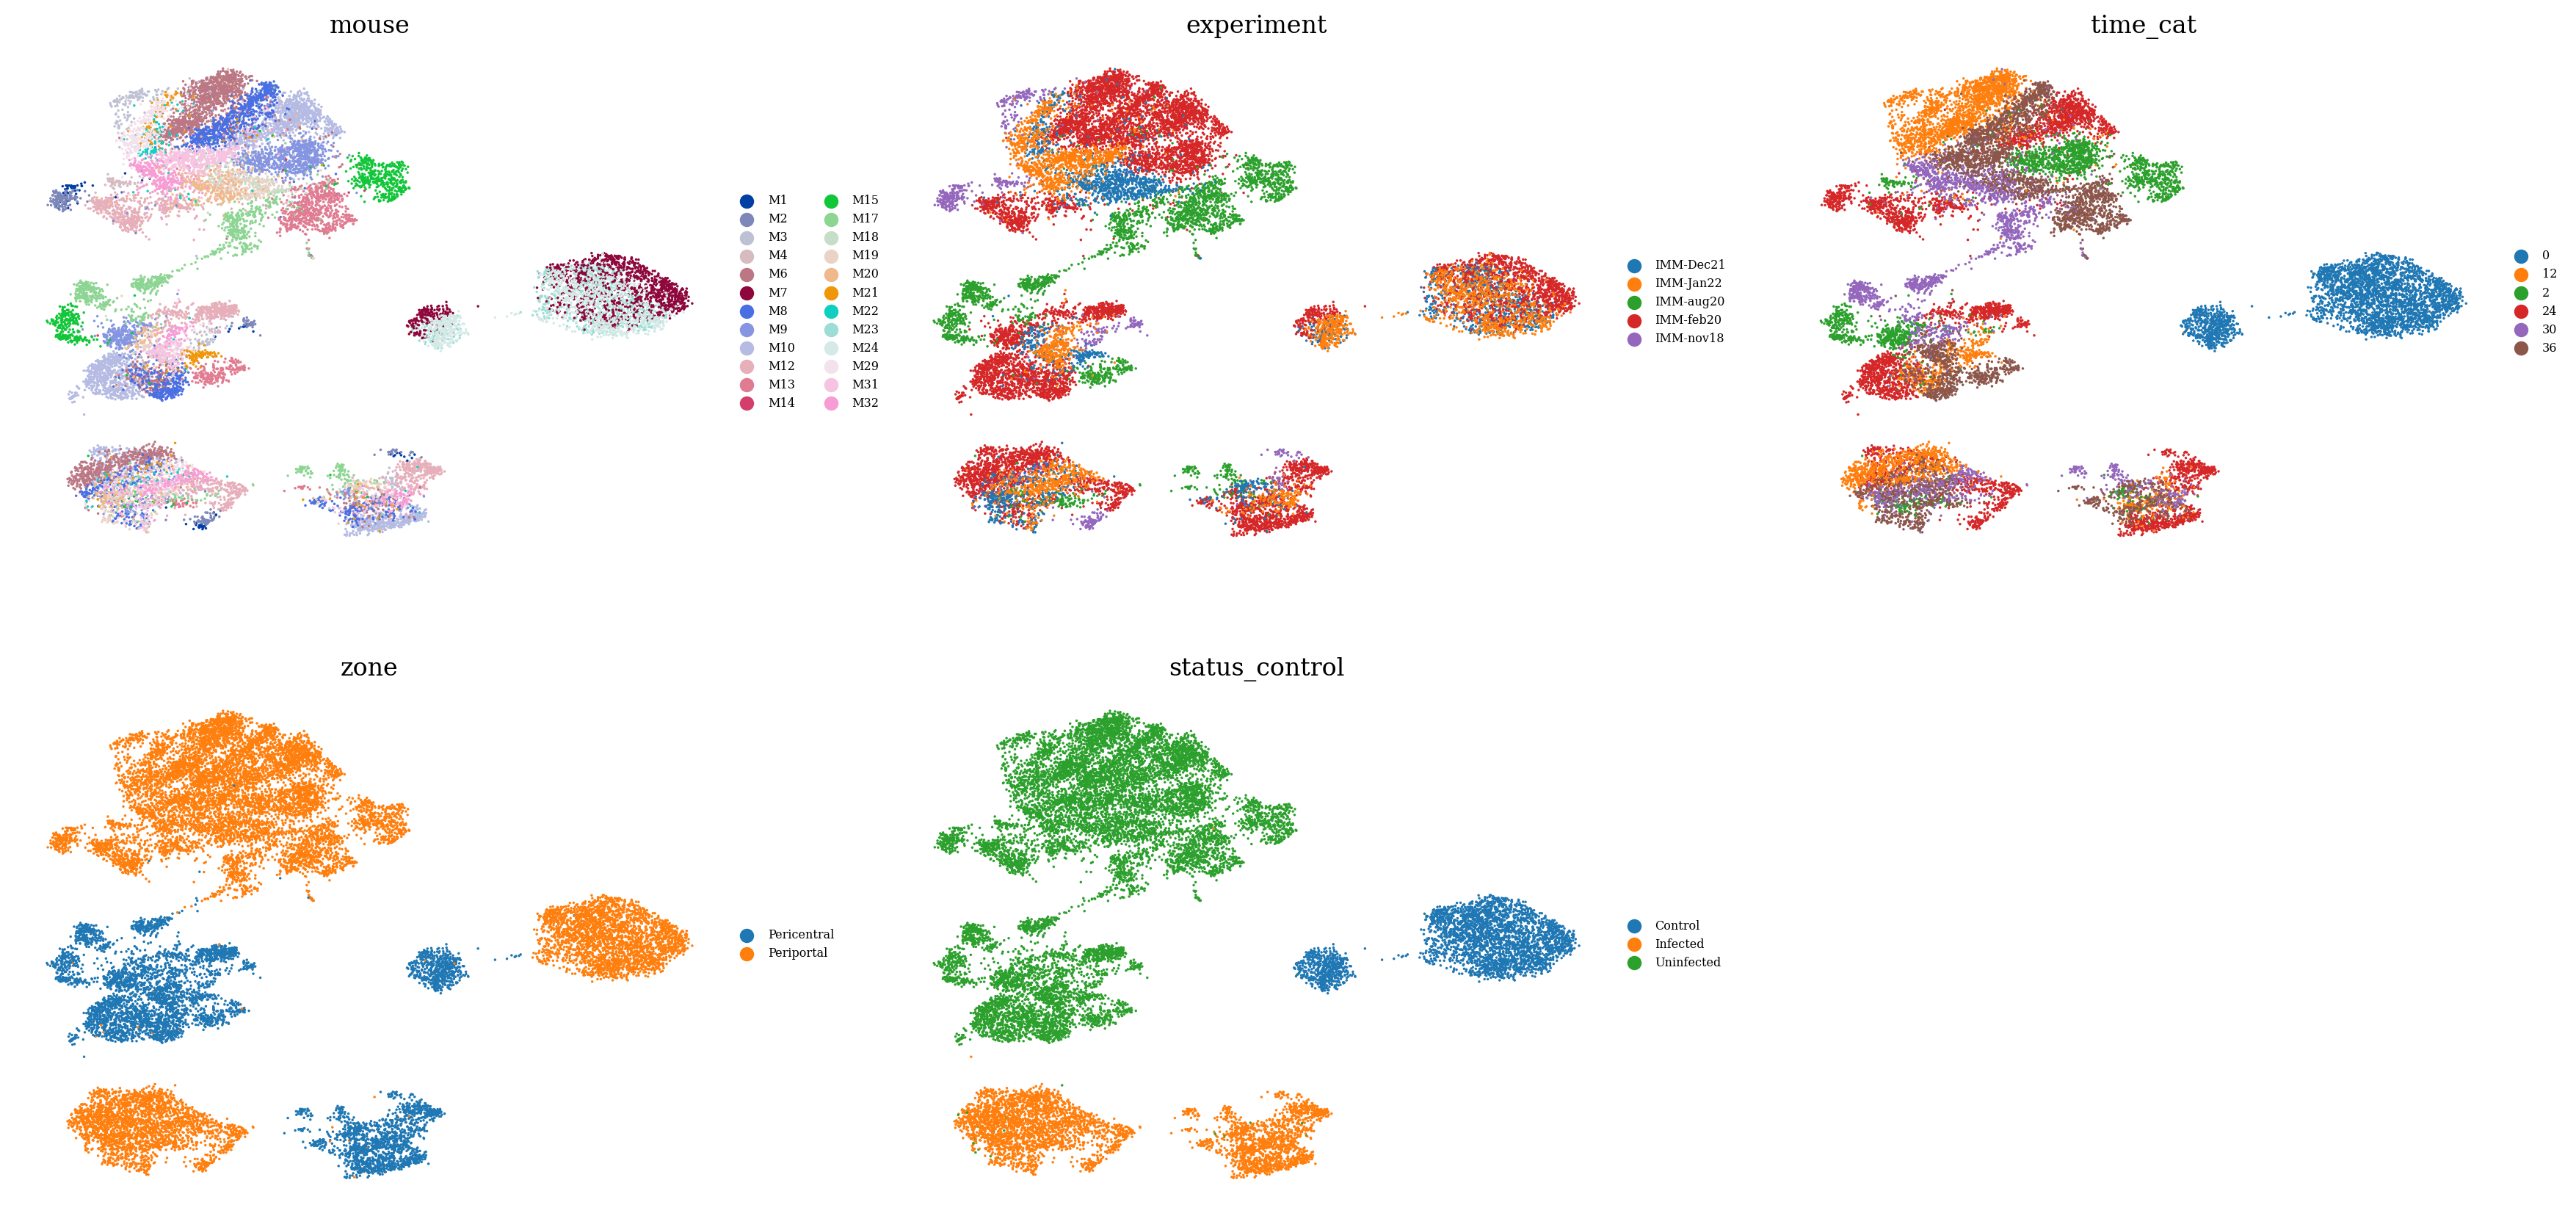

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

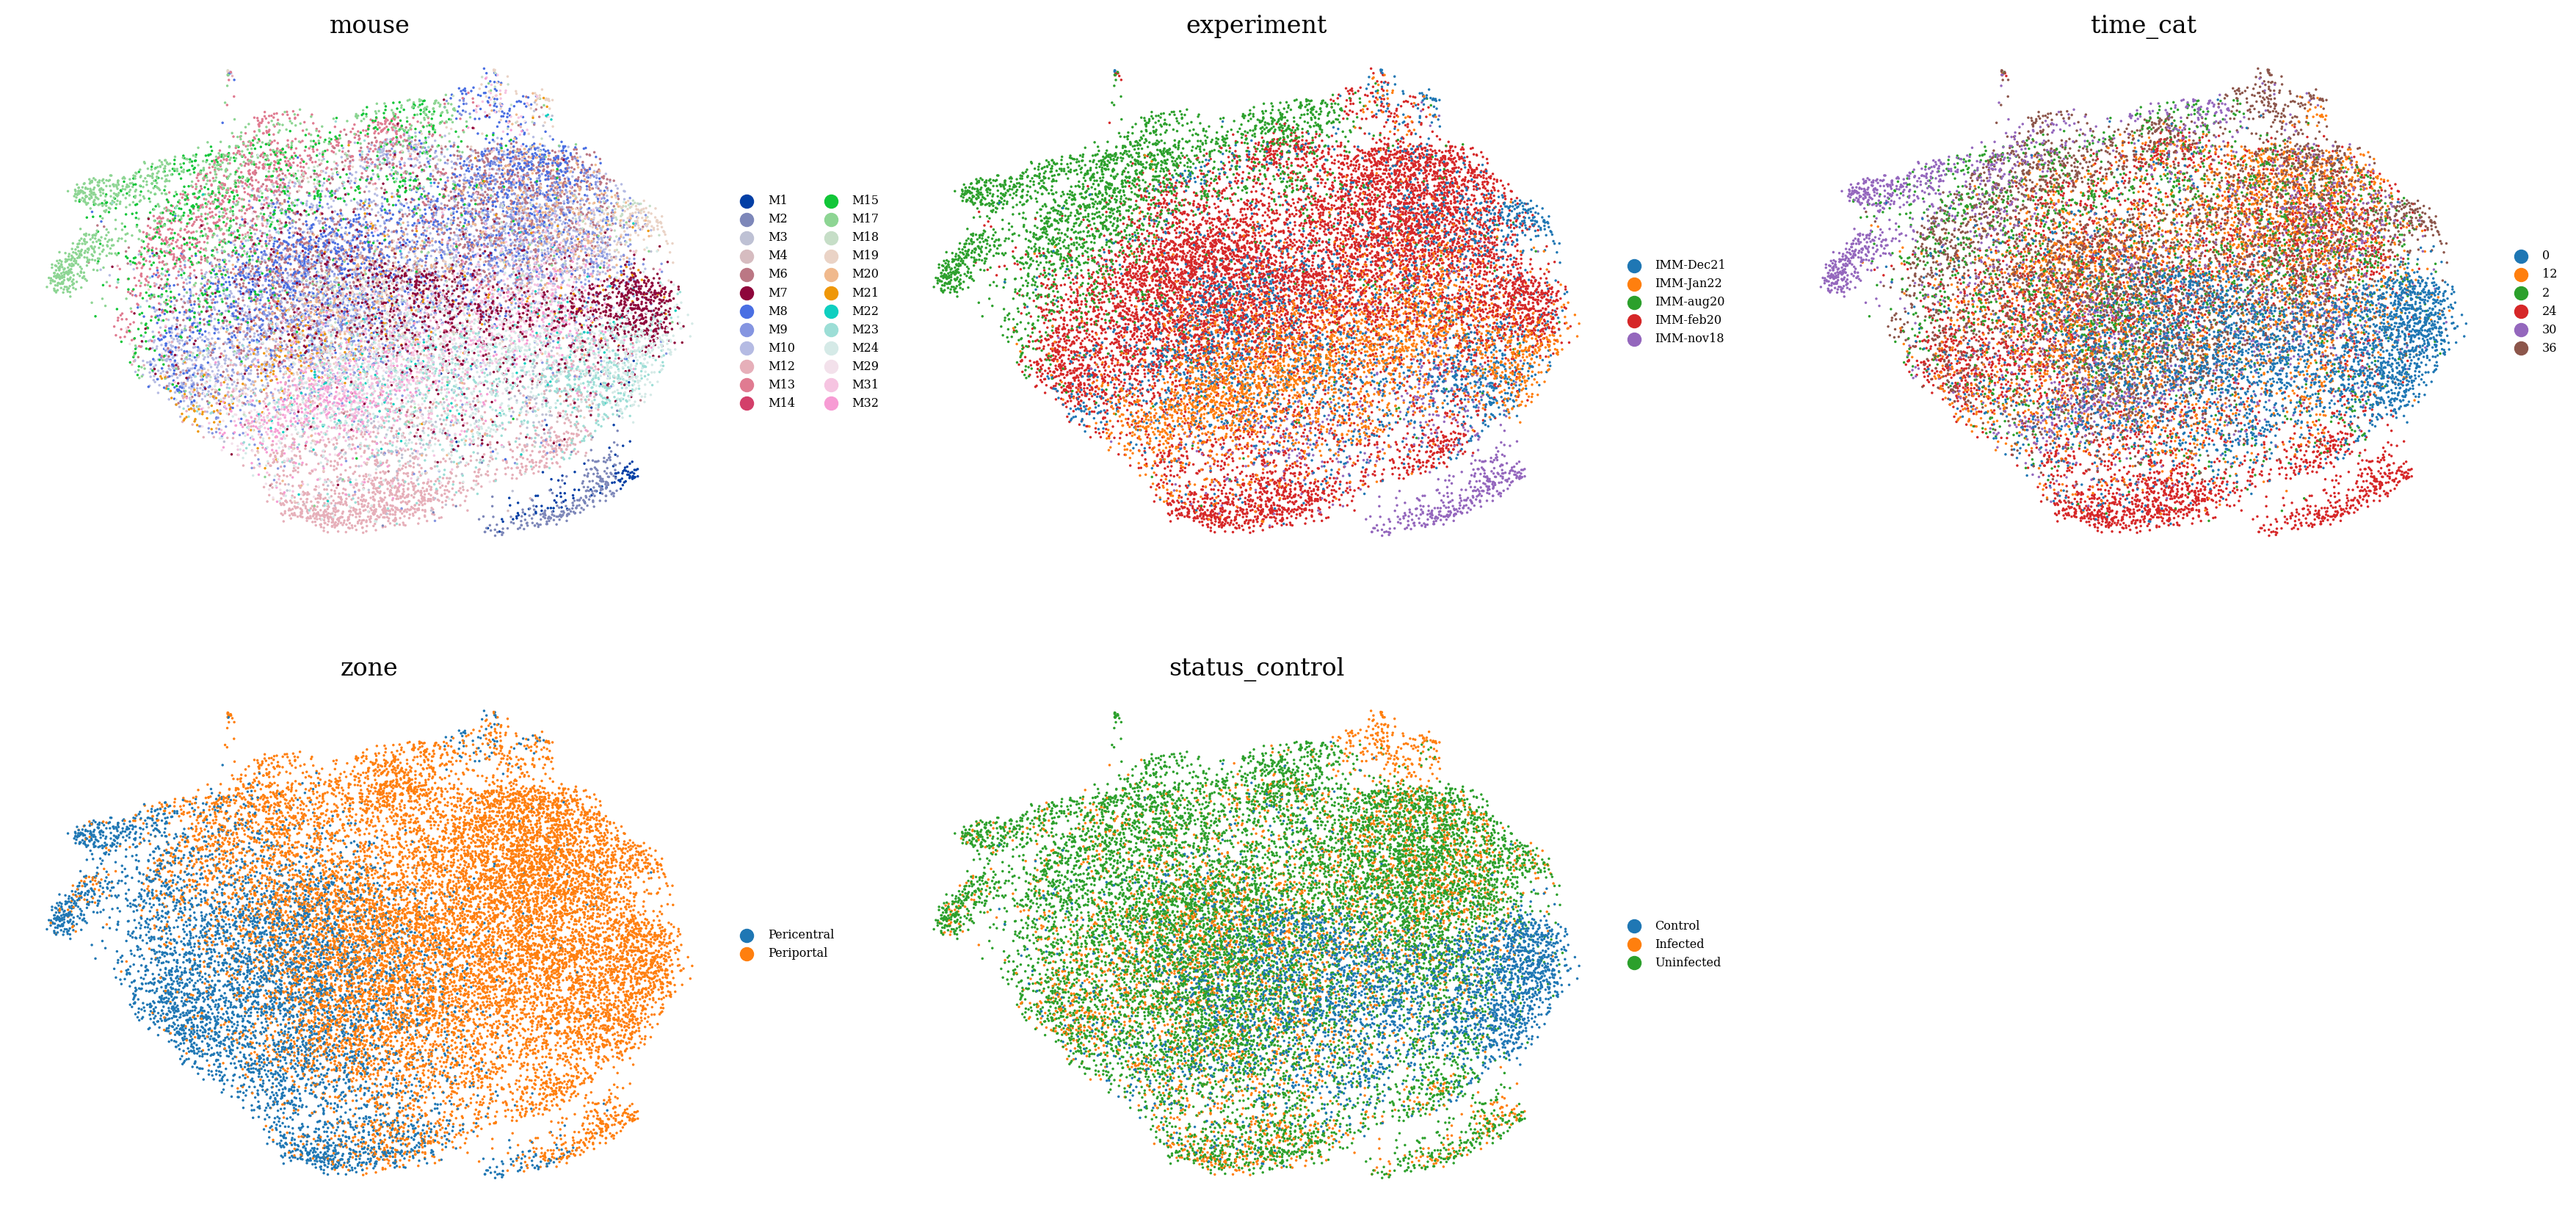

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  5%|▍         | 27/596 [00:00<00:02, 263.42it/s]

  9%|▉         | 55/596 [00:00<00:01, 272.24it/s]

 14%|█▍        | 83/596 [00:00<00:01, 275.02it/s]

 19%|█▊        | 111/596 [00:00<00:01, 276.55it/s]

 23%|██▎       | 139/596 [00:00<00:01, 277.26it/s]

 28%|██▊       | 167/596 [00:00<00:01, 276.58it/s]

 33%|███▎      | 195/596 [00:00<00:01, 276.89it/s]

 37%|███▋      | 223/596 [00:00<00:01, 277.55it/s]

 42%|████▏     | 251/596 [00:00<00:01, 277.09it/s]

 47%|████▋     | 279/596 [00:01<00:01, 277.42it/s]

 52%|█████▏    | 307/596 [00:01<00:01, 277.25it/s]

 56%|█████▌    | 335/596 [00:01<00:00, 277.06it/s]

 61%|██████    | 363/596 [00:01<00:00, 277.61it/s]

 66%|██████▌   | 391/596 [00:01<00:00, 278.02it/s]

 70%|███████   | 419/596 [00:01<00:00, 277.57it/s]

 75%|███████▌  | 447/596 [00:01<00:00, 278.29it/s]

 80%|███████▉  | 475/596 [00:01<00:00, 278.57it/s]

 84%|████████▍ | 503/596 [00:01<00:00, 278.51it/s]

 89%|████████▉ | 531/596 [00:01<00:00, 278.56it/s]

 94%|█████████▍| 559/596 [00:02<00:00, 278.41it/s]

 98%|█████████▊| 587/596 [00:02<00:00, 278.23it/s]

100%|██████████| 596/596 [00:02<00:00, 277.05it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

960

992

992

1024

1024

1056

1056

1088

1088

1120

1120

1152

1152

1184

1184

1216

1216

1248

1248

1280

1280

1312

1312

1344

1344

1376

1376

1408

1408

1440

1440

1472

1472

1504

1504

1536

1536

1568

1568

1600

1600

1632

1632

1664

1664

1696

1696

1728

1728

1760

1760

1792

1792

1824

1824

1856

1856

1888

1888

1920

1920

1952

1952

1984

1984

2016

2016

2048

2048

2080

2080

2112

2112

2144

2144

2176

2176

2208

2208

2240

2240

2272

2272

2304

2304

2336

2336

2368

2368

2400

2400

2432

2432

2464

2464

2496

2496

2528

2528

2560

2560

2592

2592

2624

2624

2656

In [23]:
np.mean(r2s)

0.901537223113294

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)